## <font color='green'> <div align="center">In the name of God </div></font>

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>

# Experiments on the MNIST dataset

##### Importing general modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sklearn
import scipy.stats as st
import scipy.io as sio
import time
import matplotlib as mpl
import os
import pickle

##### Importing modules wtitten by the author

In [2]:
from LinearDiscriminantAnalysis import LinearDiscriminantAnalysis
from LDATrainingDataPreparation import TrainingData
from NearestNeighbor import NearestNeighbor

##### Preparing matplotlib to genrate high-quality images for the paper

In [3]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 600

##### Set K=6 as in <a href="https://link.springer.com/article/10.1007/s11063-018-9906-5">Competitive Cross-Entropy Paper.</a>

In [4]:
C  = 10
K = 6
maxVqIteration = 100
L = C * K
width = 28
height = 28
N = None
NTest = None

##### Load Training and Testing Data and Normalize them

In [5]:
XTrain = sio.loadmat ('../datasets/mnist/MnistTrainX')['MnistTrainX']
yTrain = sio.loadmat ('../datasets/mnist/MnistTrainY')['MnistTrainY']
XTrain = XTrain / 255.0
if N:
    XTrain = XTrain[:N,:]
    yTrain = yTrain[:N]
    
XTest = sio.loadmat ('../datasets/mnist/MnistTestX')['MnistTestX']
yTest = sio.loadmat ('../datasets/mnist/MnistTestY')['MnistTestY']
XTest = XTest / 255.0

if NTest:
    XTest = XTest[:NTest,:]
    yTest = yTest[:NTest]

##### Prepare data for LDA.

In [6]:
np.random.seed(1)
td = TrainingData(XTrain, yTrain)

clusAlg = sklearn.cluster.KMeans(random_state=1)
clusAlg.max_iter = maxVqIteration
arrayK = np.ones(C, dtype=int)*K
start = time.time()
td.findSubclasses(arrayK, clusAlg)
end = time.time()
print ('Time for clustering: ', end - start)
filename = 'mnist_clusters.pickle'
with open(filename, 'wb') as file:
    pickle.dump(td.subclassMeans, file)

Time for clustering:  35.551568031311035


##### Show Clustering Result

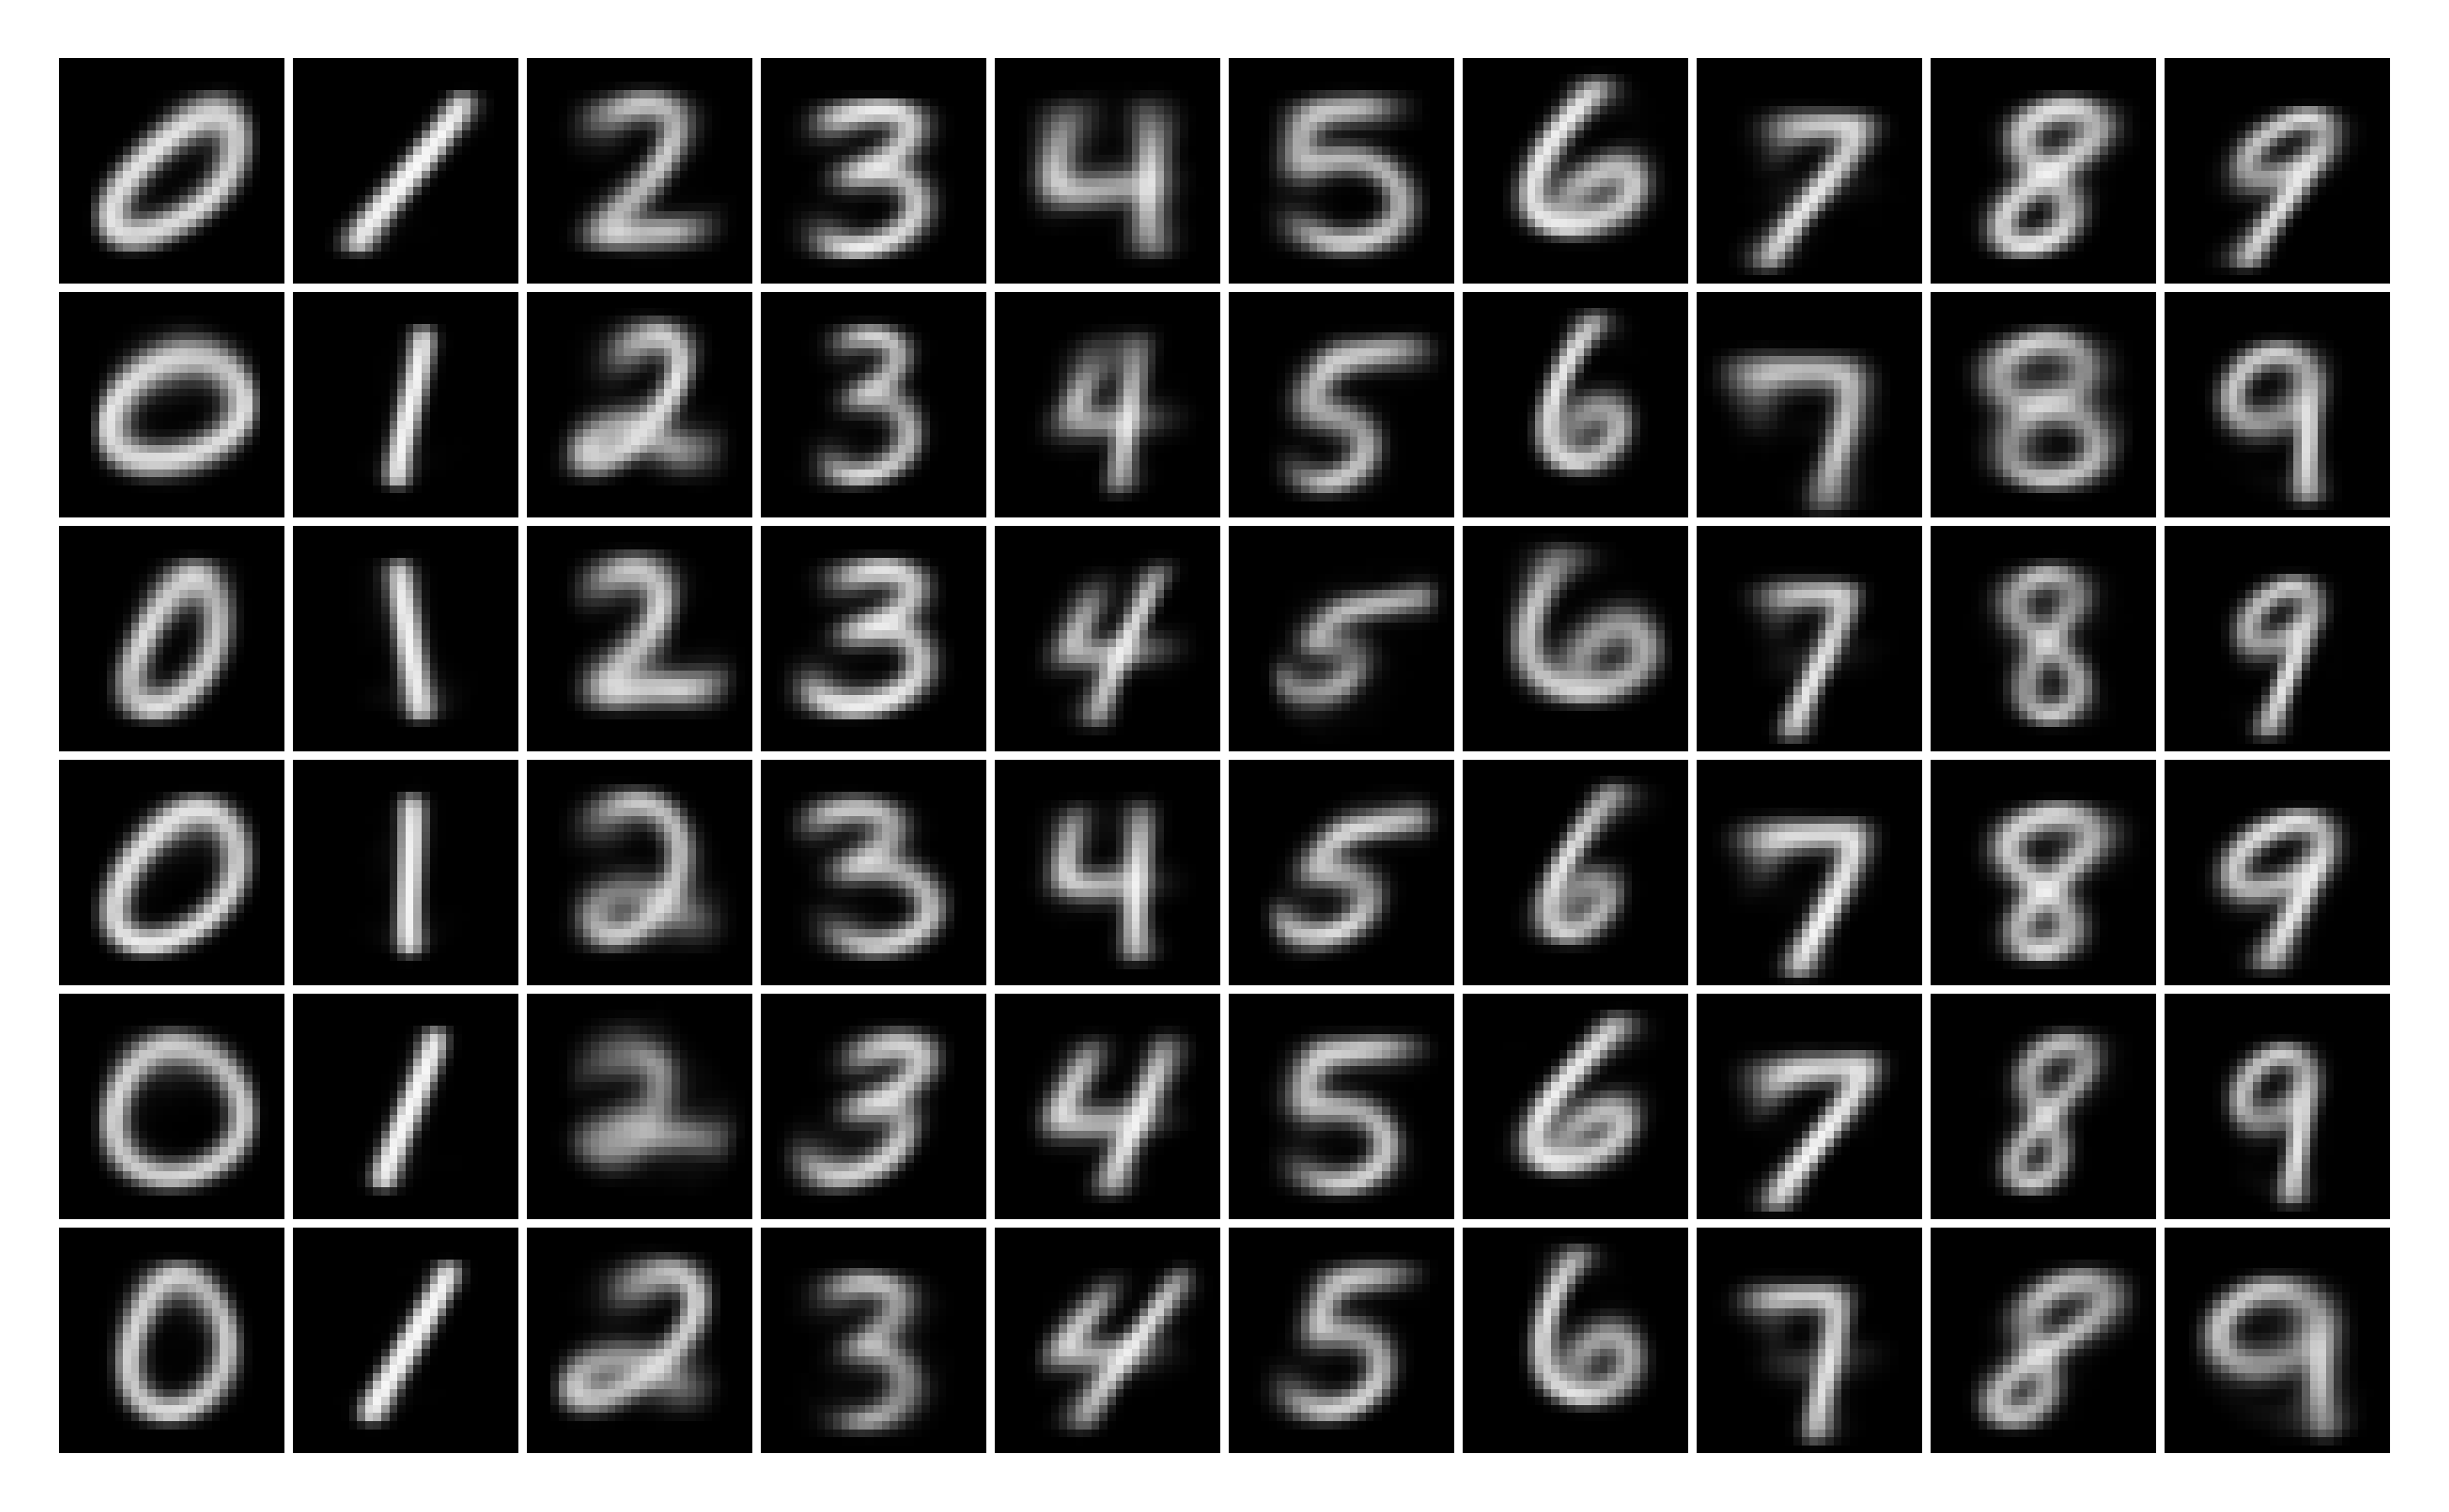

In [7]:
img = np.ones ([1+K*(height+1), 1+td.C * (width+1),3])
for c in range(td.C):
    for k in range (td.Ki[c]):
        idx1 = k*(height+1)+1
        idx2 = c*(width+1)+1
        img[idx1:idx1+height, idx2:idx2+width,0] = td.subclassMeans[c,k].reshape ([height,width])
        img[idx1:idx1+height, idx2:idx2+width,1] = img[idx1:idx1+height, idx2:idx2+width,0]
        img[idx1:idx1+height, idx2:idx2+width,2] = img[idx1:idx1+height, idx2:idx2+width,0]
plt.axis('off')
plt.imshow (img)
fn = 'mnist_clustering_reg_1_0' + '.png'
plt.imsave(fn, img)        
plt.show()

##### The function for performing an experiment. 

In [8]:
def performExperiment (solver, metric_learning, S2, reg, options):
    print ('solver = ', solver, 'metric_learning = ', metric_learning, ' regularions parameter = ', reg)
    lda = LinearDiscriminantAnalysis(td, solver, metric_learning, 'Sb', S2, reg, 0.0001)
    
    start = time.time()
    lda.fitFeatureExtractor()
    end = time.time()
    print ('lda.fitFeatureExtractor took time: ', end - start)
    
    if solver == 'orthogonal_centroid':
        lda.solver = 'eigen'
        
    objective = lda.objective()
    print('Objective: ' , objective)
    
    objective2 = lda.objective2()
    print('Objective(SecondMethod): ' , objective2)    
        
    if 'NN' in options:
        print('***Classification results based on Nearest Neighbor classifier***')        
        start = time.time()
        XTrainFtr = lda.transform (XTrain)
        XTestFtr  = lda.transform (XTest)
        acc = NearestNeighbor (XTrainFtr, yTrain, XTestFtr, yTest)
        end = time.time()
        print ('classification by NearestNeighbor took time: ', end - start)
        print ('Accuracy of Nearest Neighbor classifier is: ', acc)   
    
    if 'Bayes' in options:
        # Compute classification error
        print('***Classification results based on Bayes optimal classifier***')
        start = time.time()
        lda.fitBayesLinearClassifier()
        yHat = lda.classifyByBayesClassifier(XTest)
        end = time.time()
        print ('lda.classifyByBayesLinearClassifier took time: ', end - start)
        yHat = np.array(yHat, dtype='int')
        outVal = sklearn.metrics.accuracy_score(yTest, yHat)
        print('Test classification error: ' + str(outVal))
    
    if 'Max' in options:        
        print('***Classification results based on max output***')
        yHat = lda.classifyByMaxClassifier(XTest)
        yHat = np.array(yHat, dtype='int')
        outVal = sklearn.metrics.accuracy_score(yTest, yHat)
        print('Test classification error: ' + str(outVal))
        
    if 'Depict' in options:
        img = lda.GenerateImagesOfLinearFeatureExtractorWeights(width, height, color = 'gray', nImages=1, rows=K, cols = C)
        plt.axis('off')
        plt.imshow (img[0])
        fn = 'mnist_{}_{}_reg_1_0'.format(solver,metric_learning) + '.png'
        plt.imsave(fn, img[0])
        print (fn)
        plt.show()
        
    if solver == 'orthogonal_centroid':
        lda.solver = 'orthogonal_centroid'
        
    #return lda

##### For solver='eigen', S2=St and S2=Sw should return the same result

solver =  eigen metric_learning =    regularions parameter =  1
lda.fitFeatureExtractor took time:  1.862140417098999
Objective:  7.347679154525613
Objective(SecondMethod):  7.347679154212848
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  281.0548644065857
Accuracy of Nearest Neighbor classifier is:  0.9724
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  2.0919318199157715
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145
mnist_eigen__reg_1_0.png


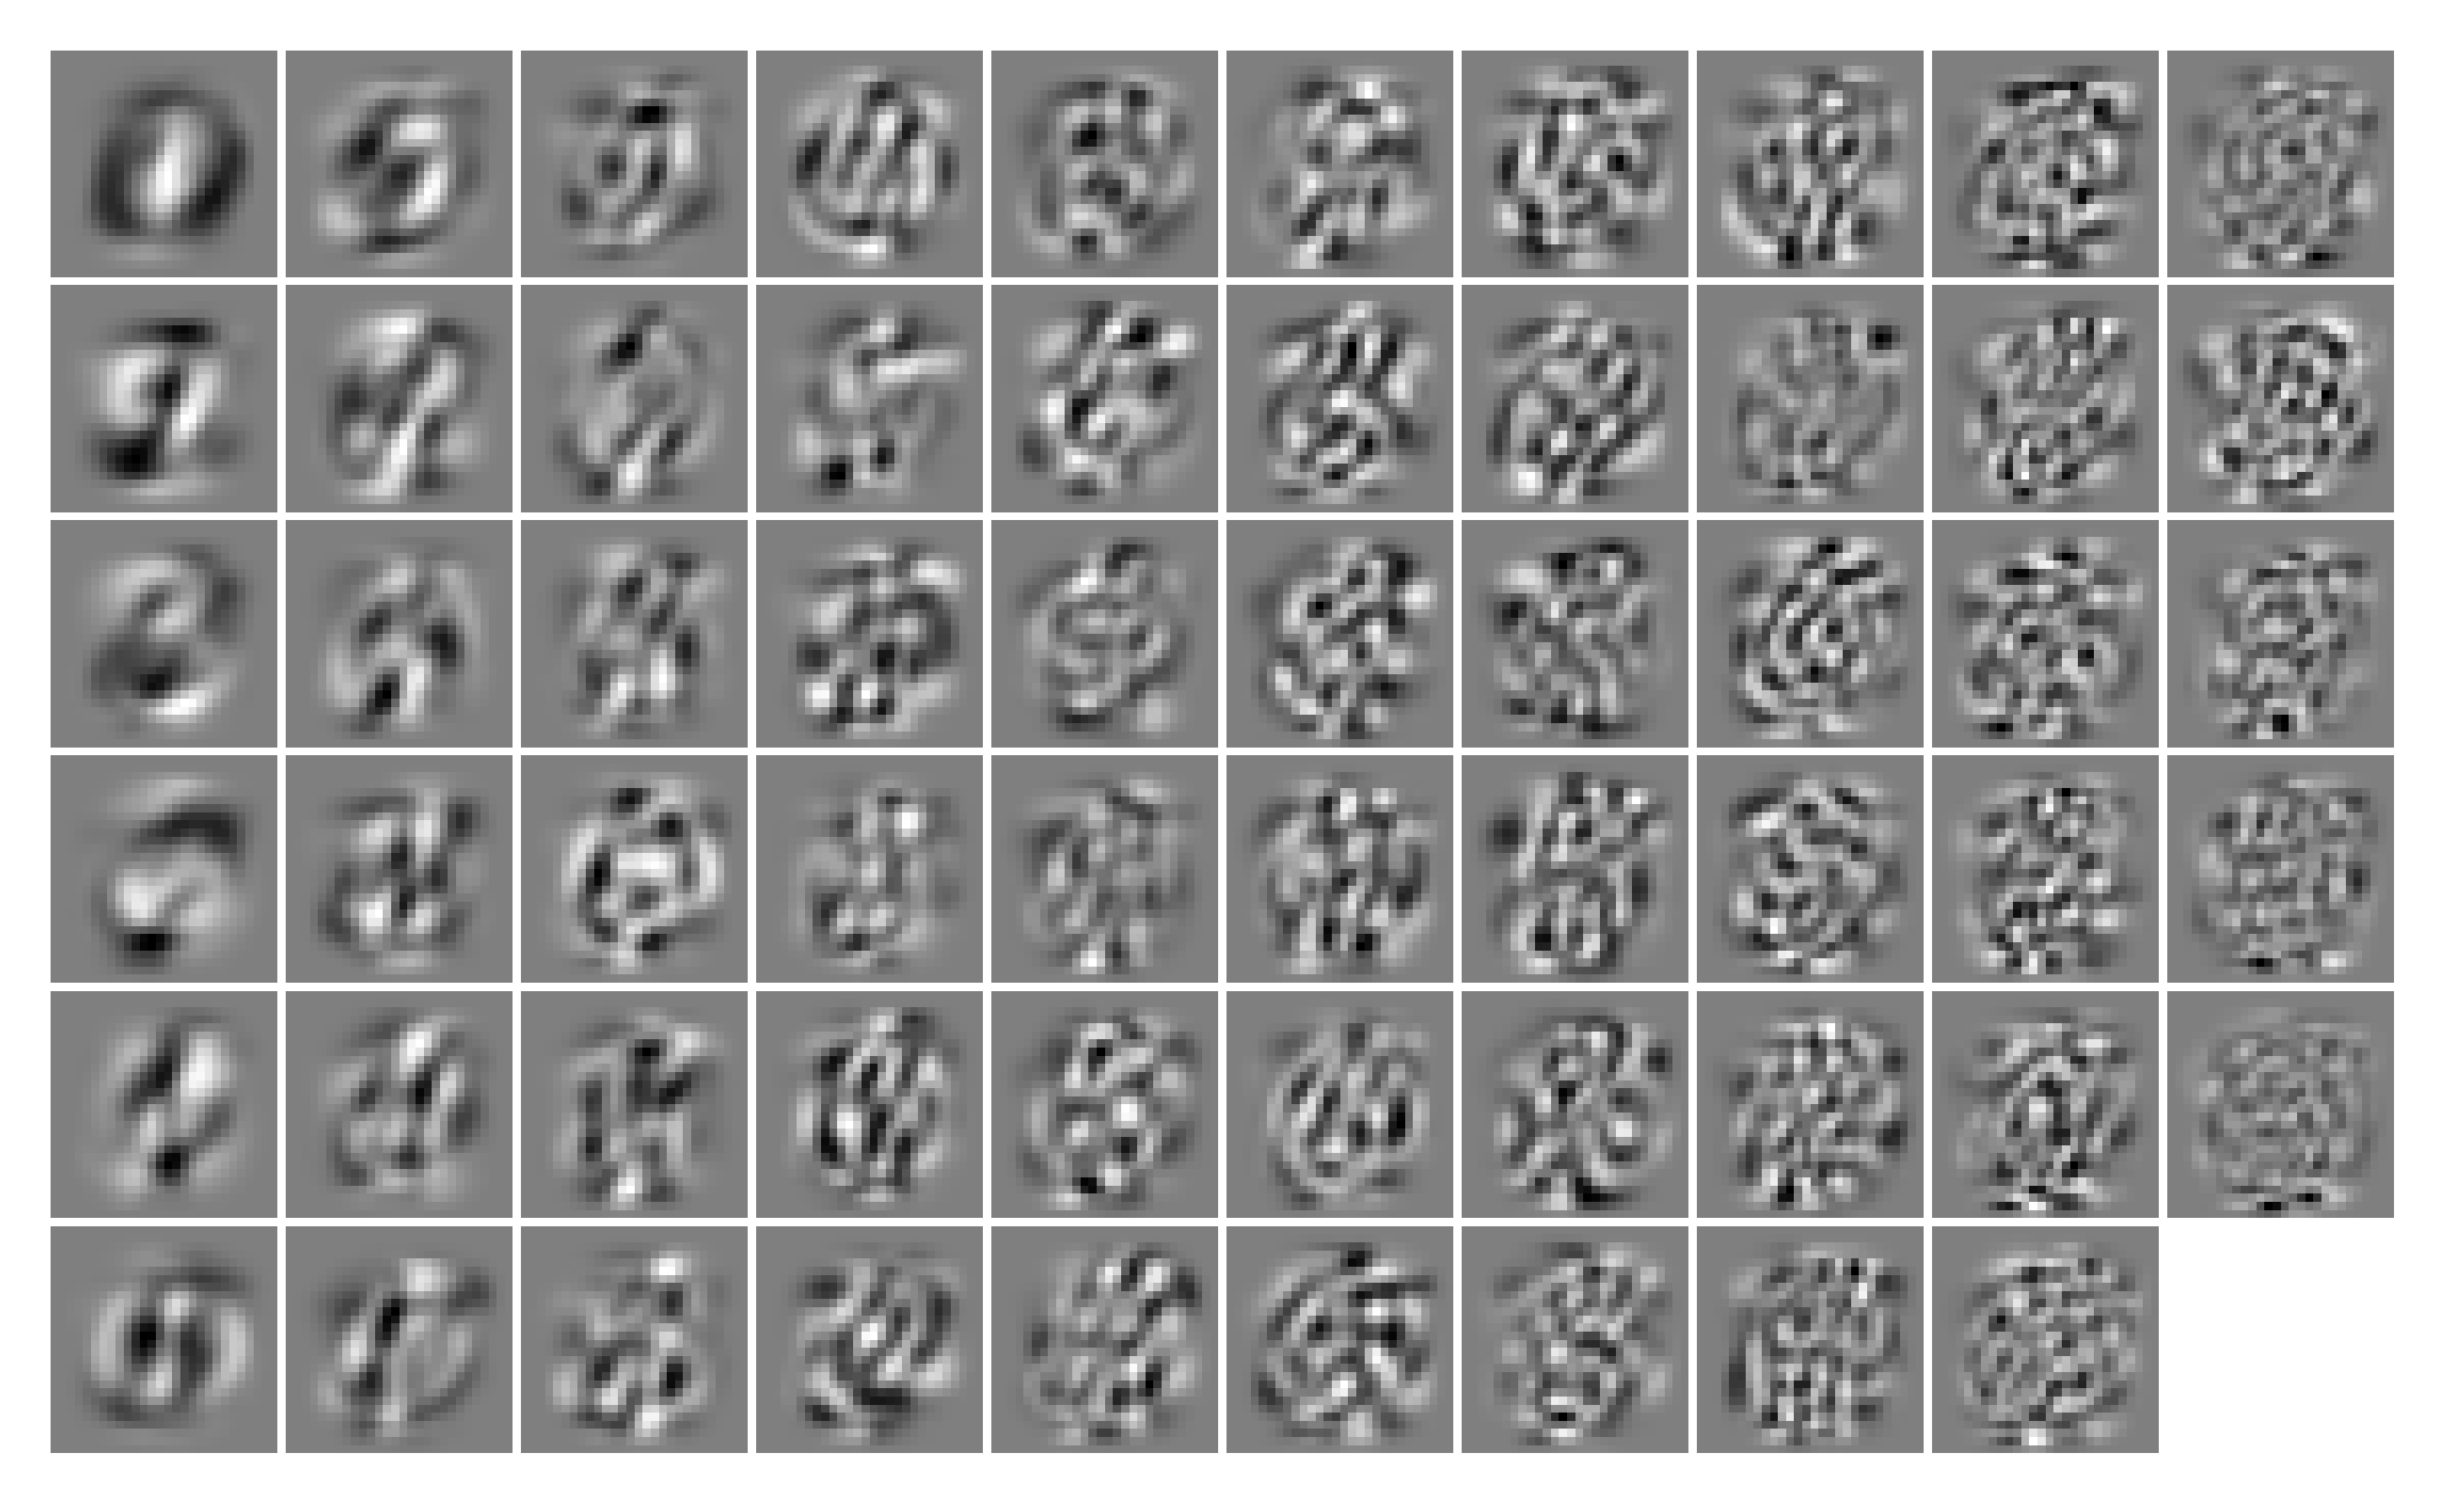

In [9]:
options = ['NN', 'Bayes', 'Max', 'Depict']
#options = ['Bayes', 'Max']
performExperiment (solver = 'eigen', metric_learning = '', S2='St', reg=1, options=options)

solver =  eigen metric_learning =    regularions parameter =  1
lda.fitFeatureExtractor took time:  1.4922099113464355
Objective:  7.347679154525612
Objective(SecondMethod):  7.34767915421285
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  279.32317781448364
Accuracy of Nearest Neighbor classifier is:  0.9724
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  1.3070123195648193
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145
mnist_eigen__reg_1_0.png


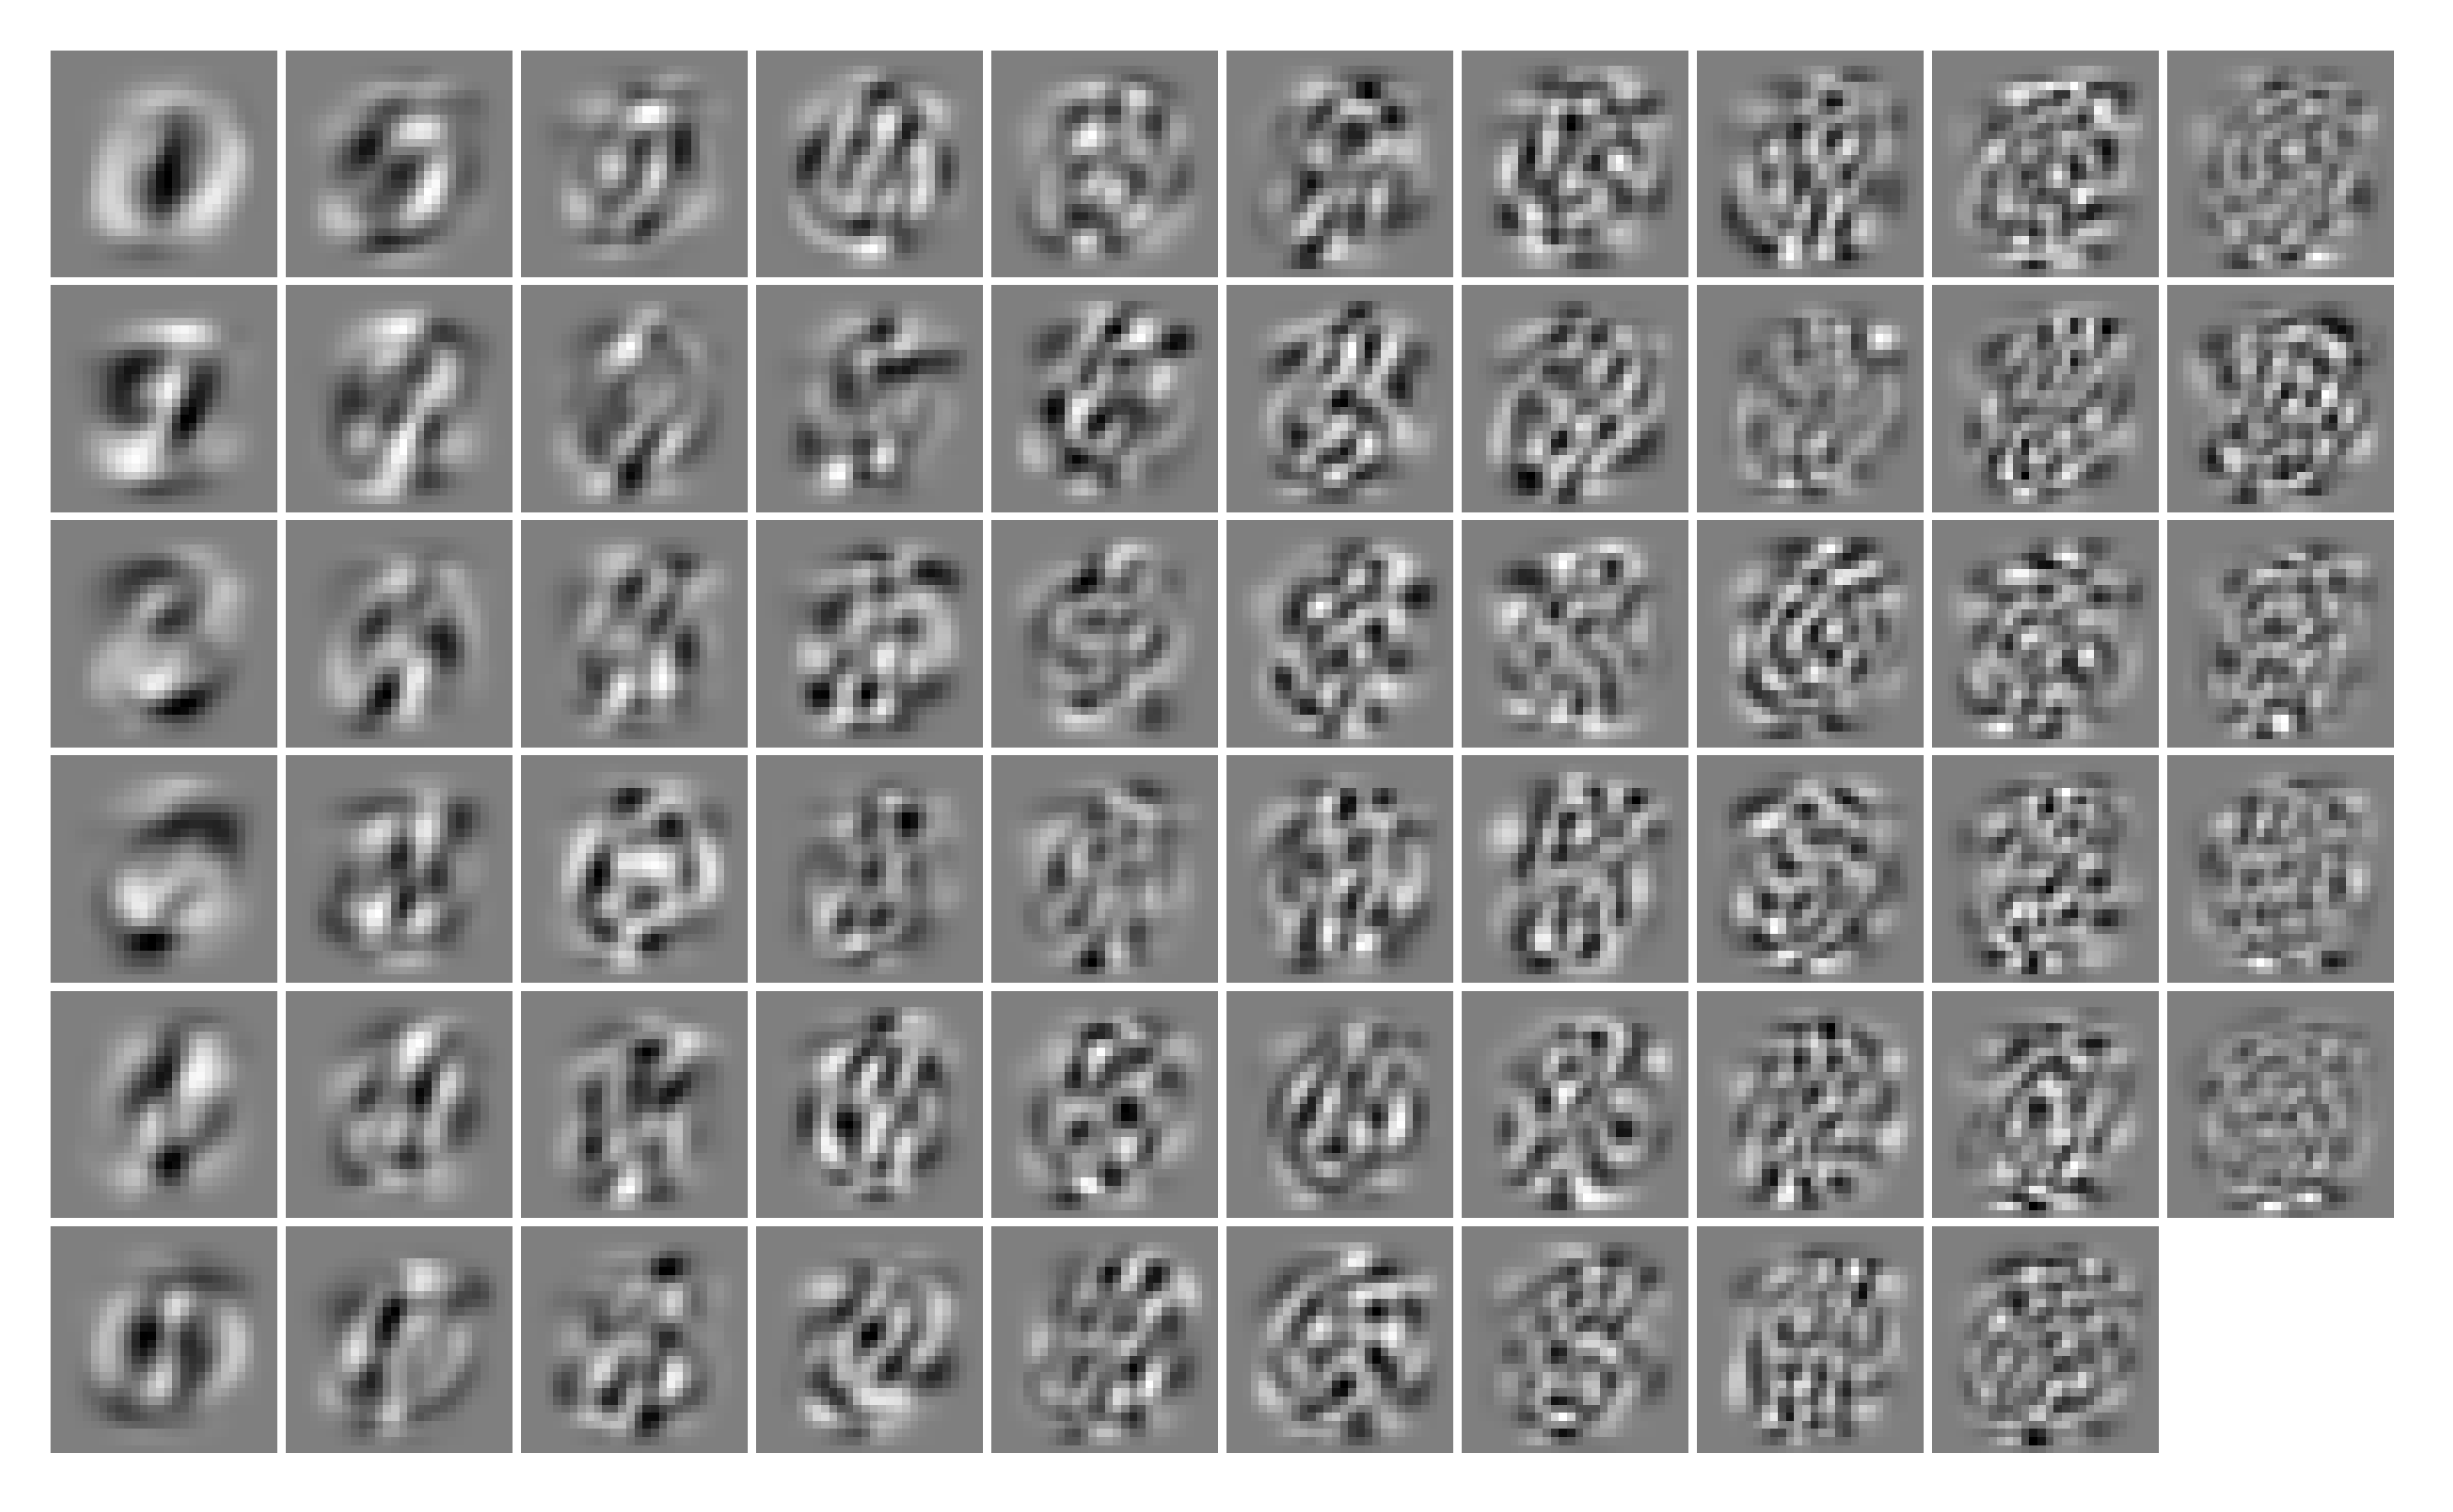

In [10]:
performExperiment (solver = 'eigen', metric_learning = '', S2='Sw', reg=1, options=options)

##### Repeating the above experiments using the proposed method ('ghiasi_lstsq')
In the proposed method, we should always use S2=St.
We expect the objective value to be the same as traditional LDA (above).
However, the learned feature extractors are hightly interpretable

solver =  ghiasi_lstsq metric_learning =  none  regularions parameter =  1
lda.fitFeatureExtractor took time:  2.0657131671905518
Objective:  7.347679154525624
Objective(SecondMethod):  7.347679153682167
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  289.07914113998413
Accuracy of Nearest Neighbor classifier is:  0.9709
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  2.218967914581299
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145
mnist_ghiasi_lstsq_none_reg_1_0.png


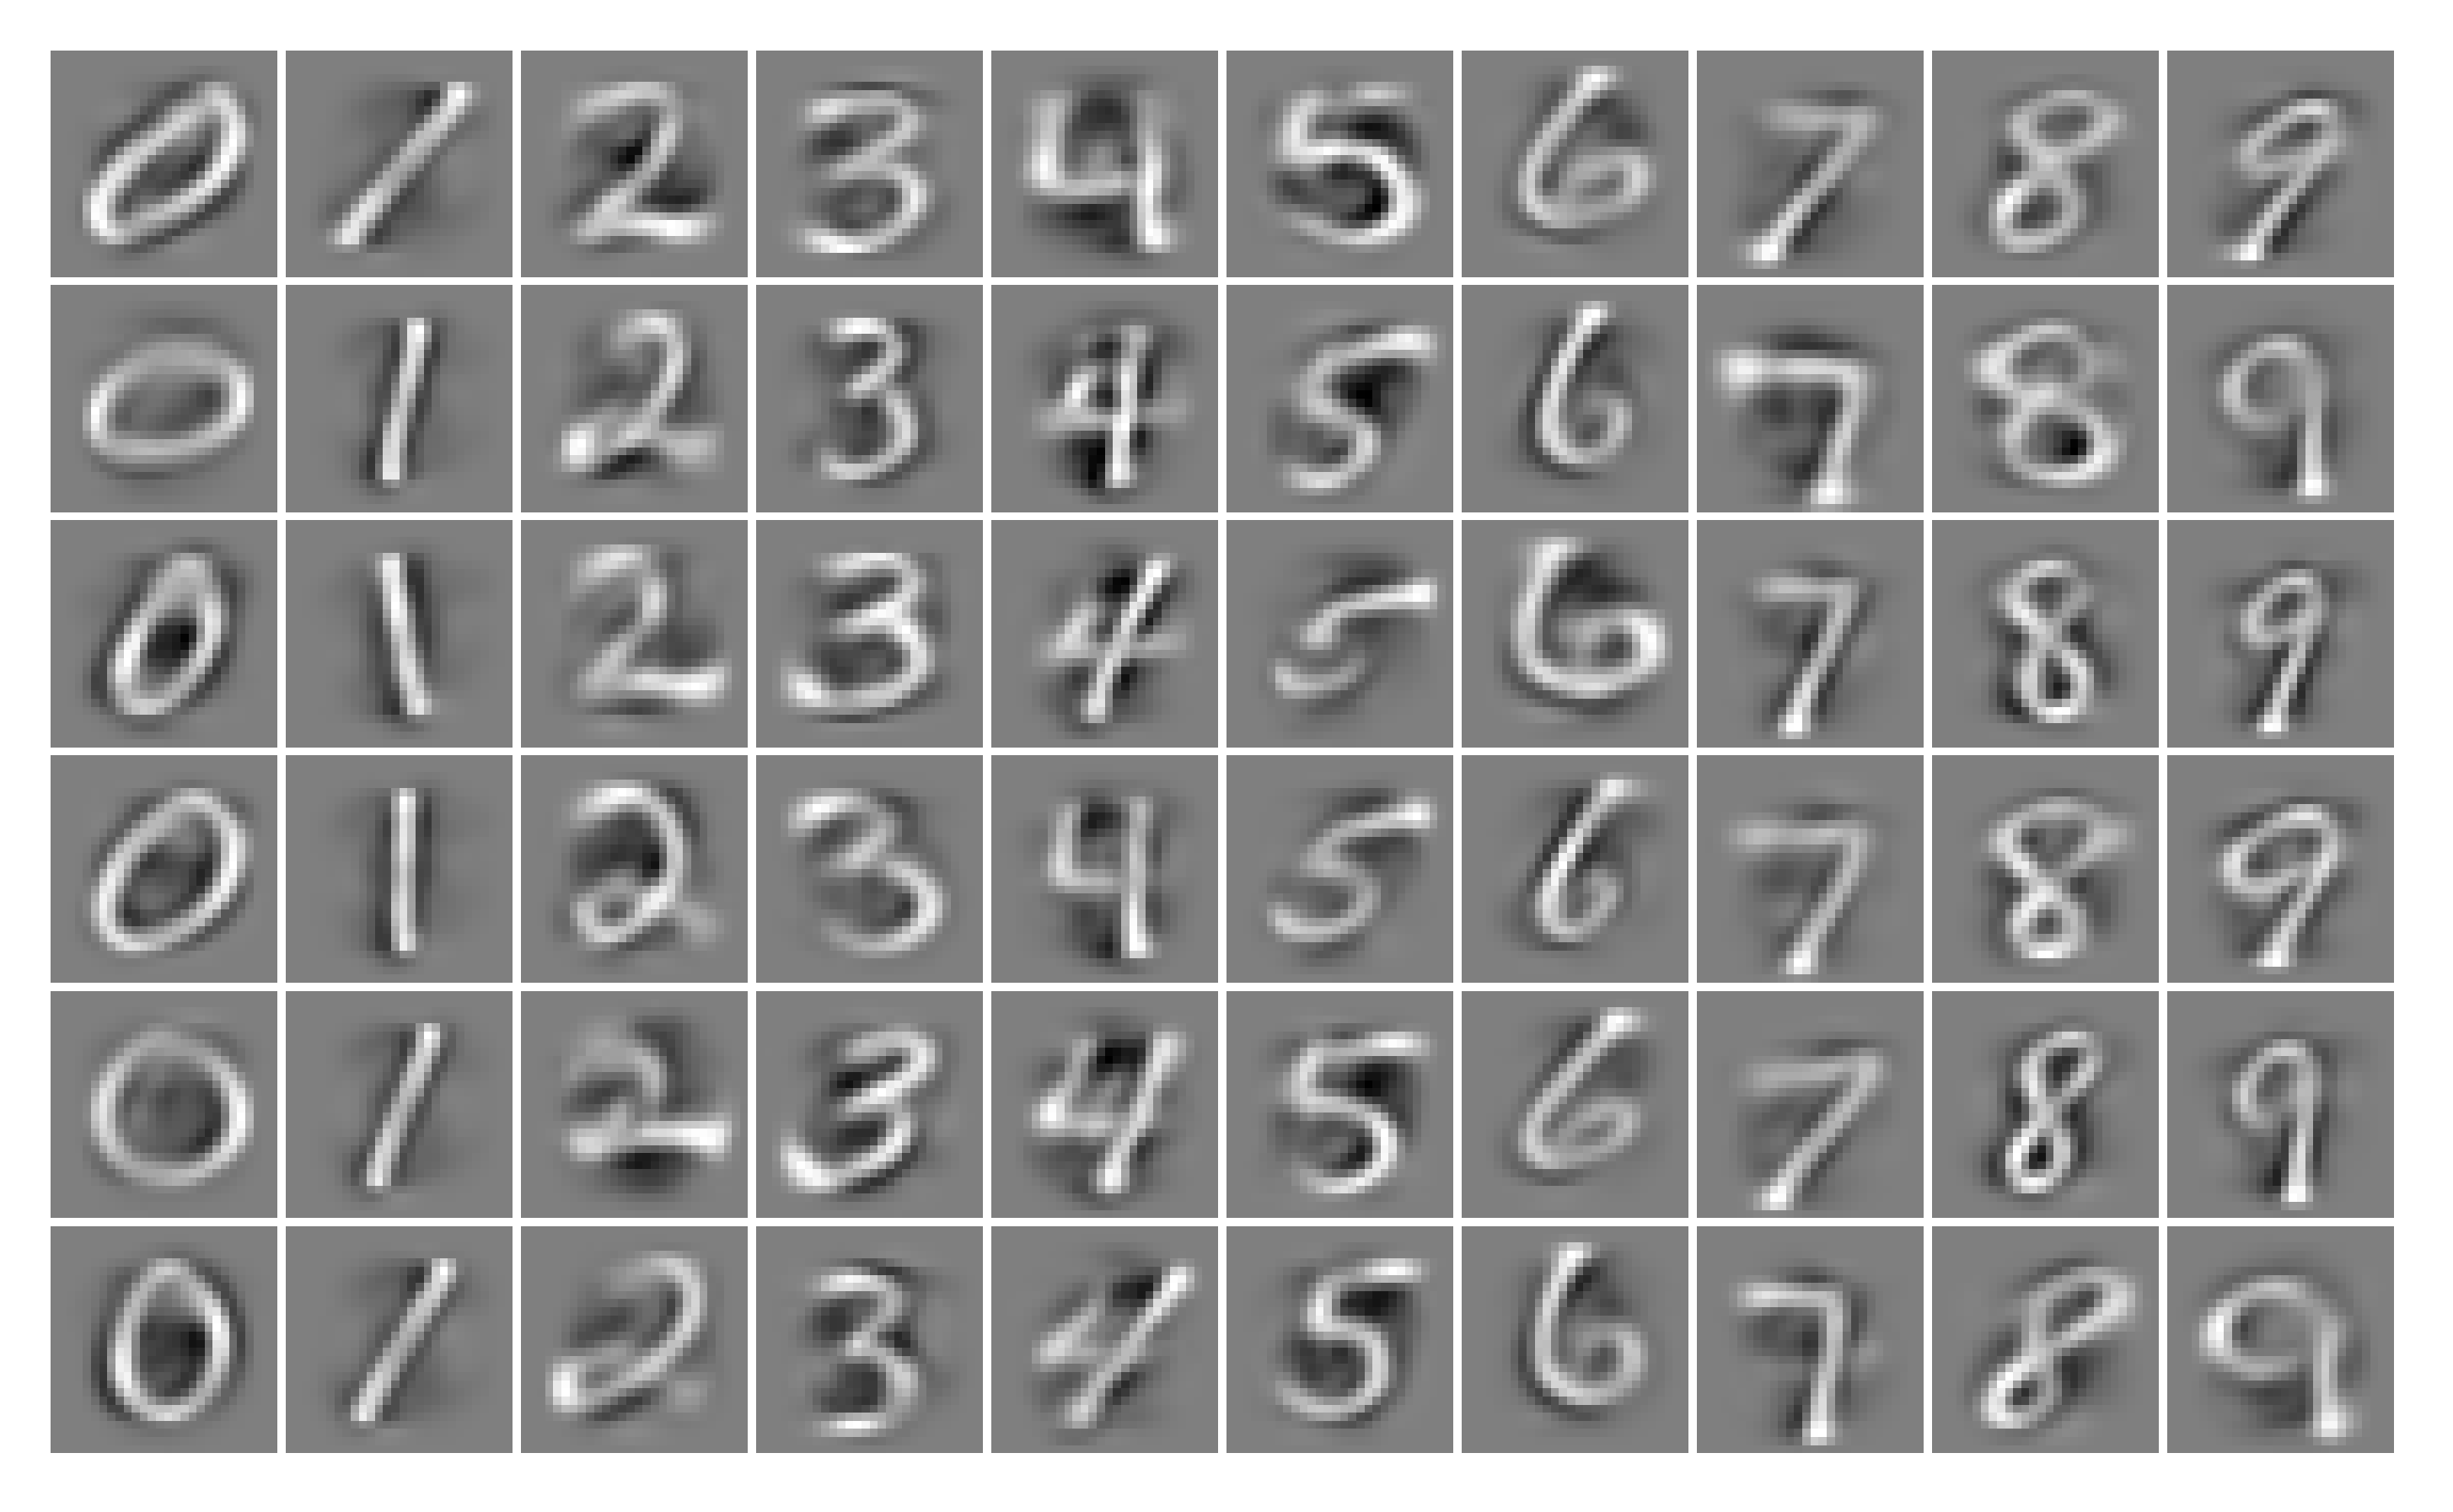

In [11]:
options = ['NN', 'Bayes', 'Max', 'Depict']
performExperiment ('ghiasi_lstsq', metric_learning = 'none', S2='St', reg=1,  options=options)

solver =  ghiasi_lstsq metric_learning =  eig  regularions parameter =  1
lda.fitFeatureExtractor took time:  2.2825069427490234
Objective:  7.347679154525615
Objective(SecondMethod):  7.347679154212852
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  282.5699486732483
Accuracy of Nearest Neighbor classifier is:  0.9726
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  2.07918381690979
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145
mnist_ghiasi_lstsq_eig_reg_1_0.png


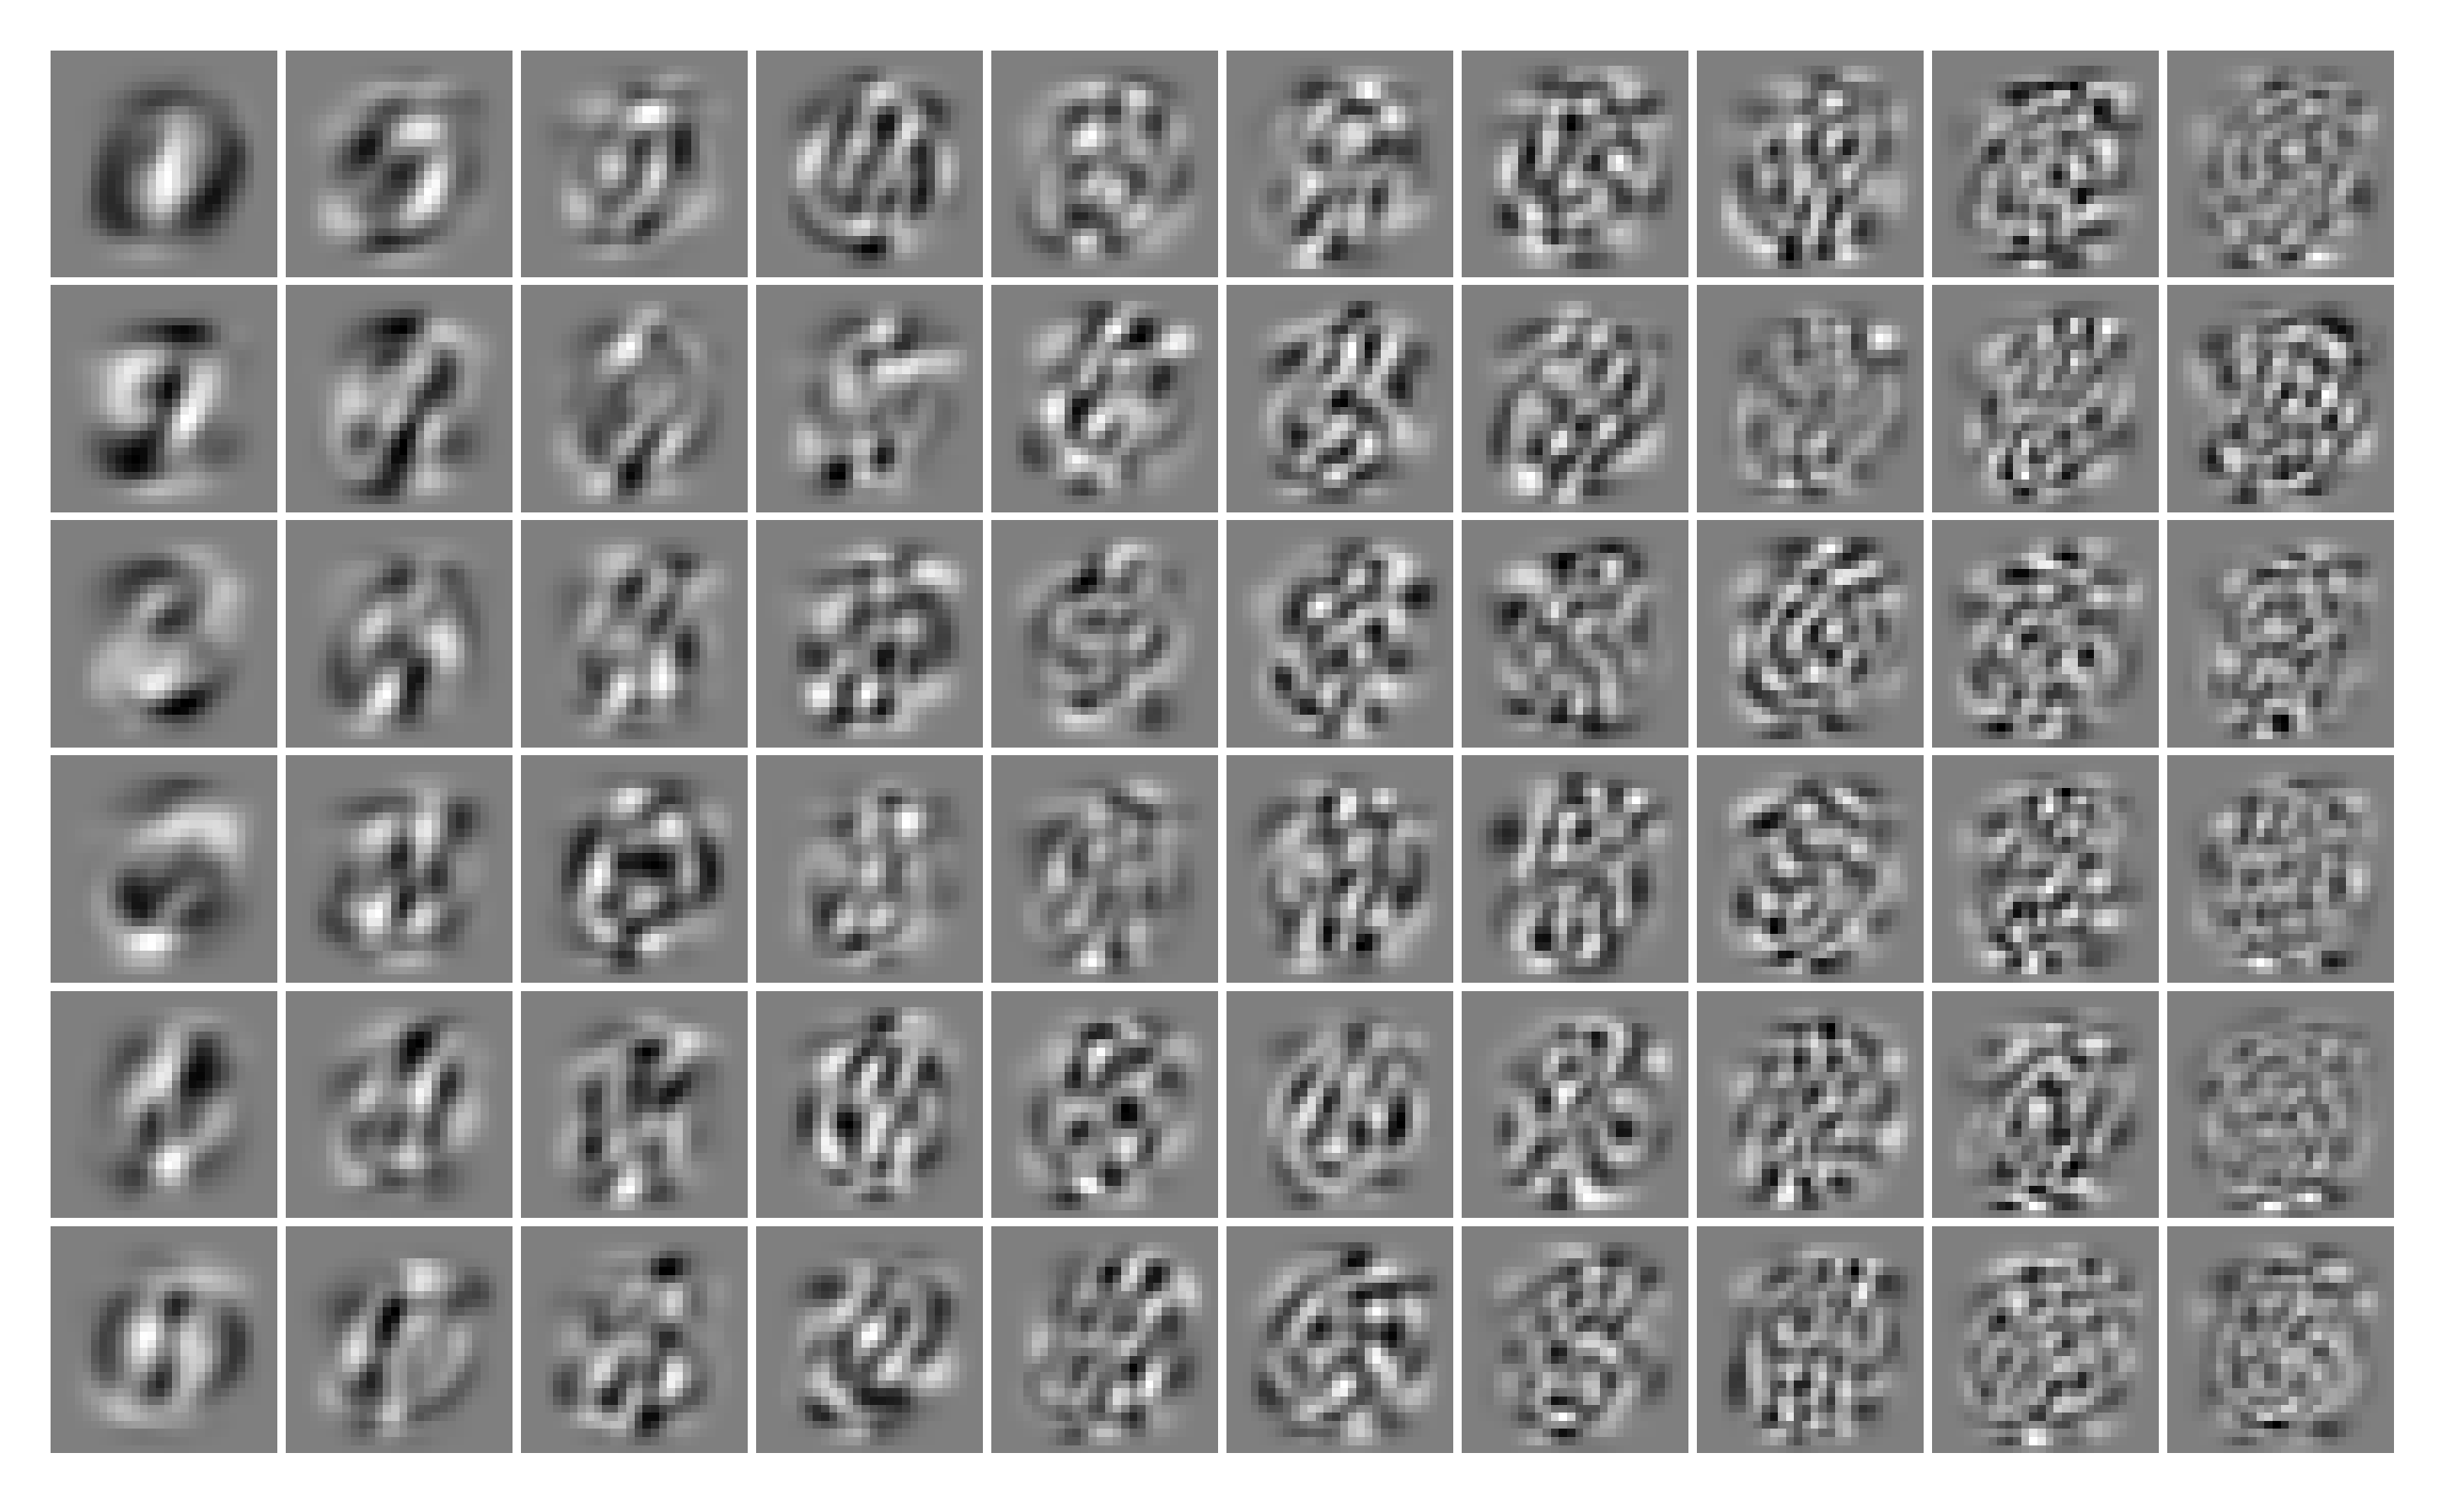

In [12]:
options = ['NN', 'Bayes', 'Max', 'Depict']
performExperiment ('ghiasi_lstsq', metric_learning = 'eig', S2='St', reg=1,  options=options)

### Solvers based on Singular Value Decomposition

In scikit-learn 0.21.3, erroneously, S2=Sw is used with sovler='svd'.
solver='svd' works only with S2=St.

solver =  svd metric_learning =    regularions parameter =  1
lda.fitFeatureExtractor took time:  8.948276996612549
Objective:  7.3476791545254905
Objective(SecondMethod):  7.347679154212724
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  279.2487668991089
Accuracy of Nearest Neighbor classifier is:  0.9724
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  8.833277940750122
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145
mnist_svd__reg_1_0.png


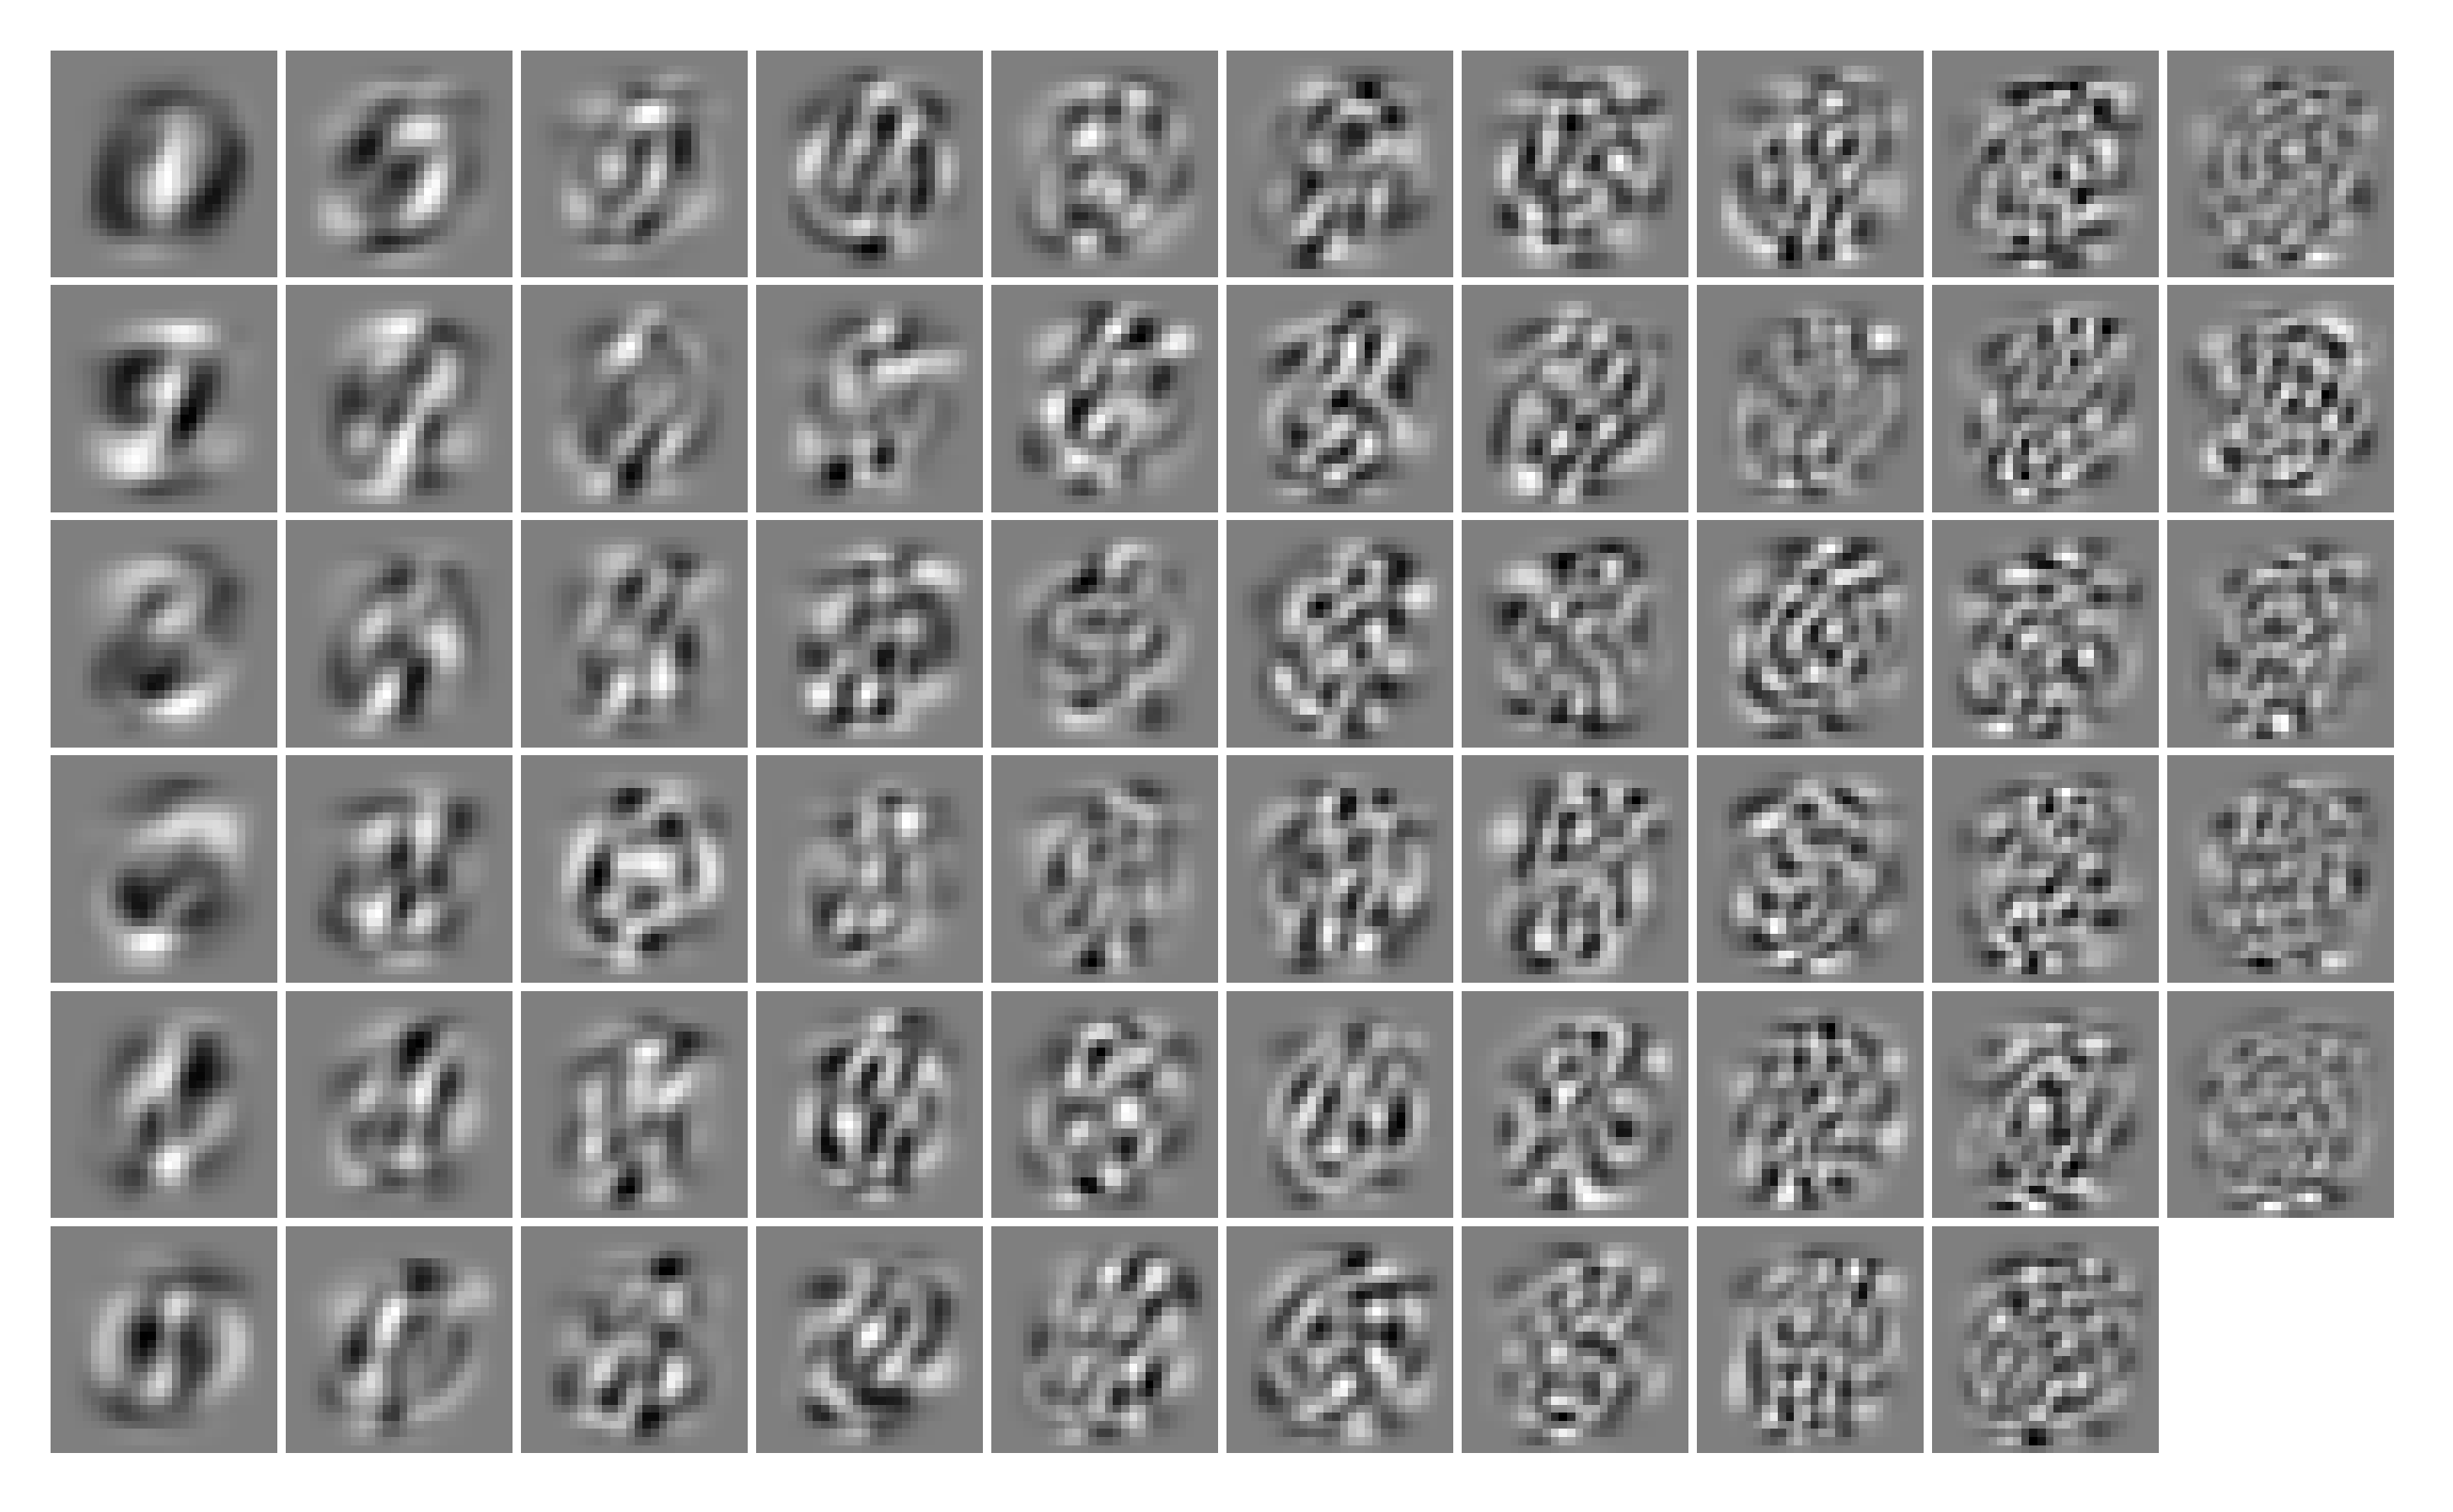

In [13]:
performExperiment ('svd', metric_learning = '', S2='St',reg = 1, options=options)

solver =  ghiasi_svd metric_learning =  none  regularions parameter =  1
lda.fitFeatureExtractor took time:  8.50159215927124
Objective:  7.347679154525648
Objective(SecondMethod):  7.347679153682177
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  282.9036056995392
Accuracy of Nearest Neighbor classifier is:  0.9709
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  8.688831090927124
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145
mnist_ghiasi_svd_none_reg_1_0.png


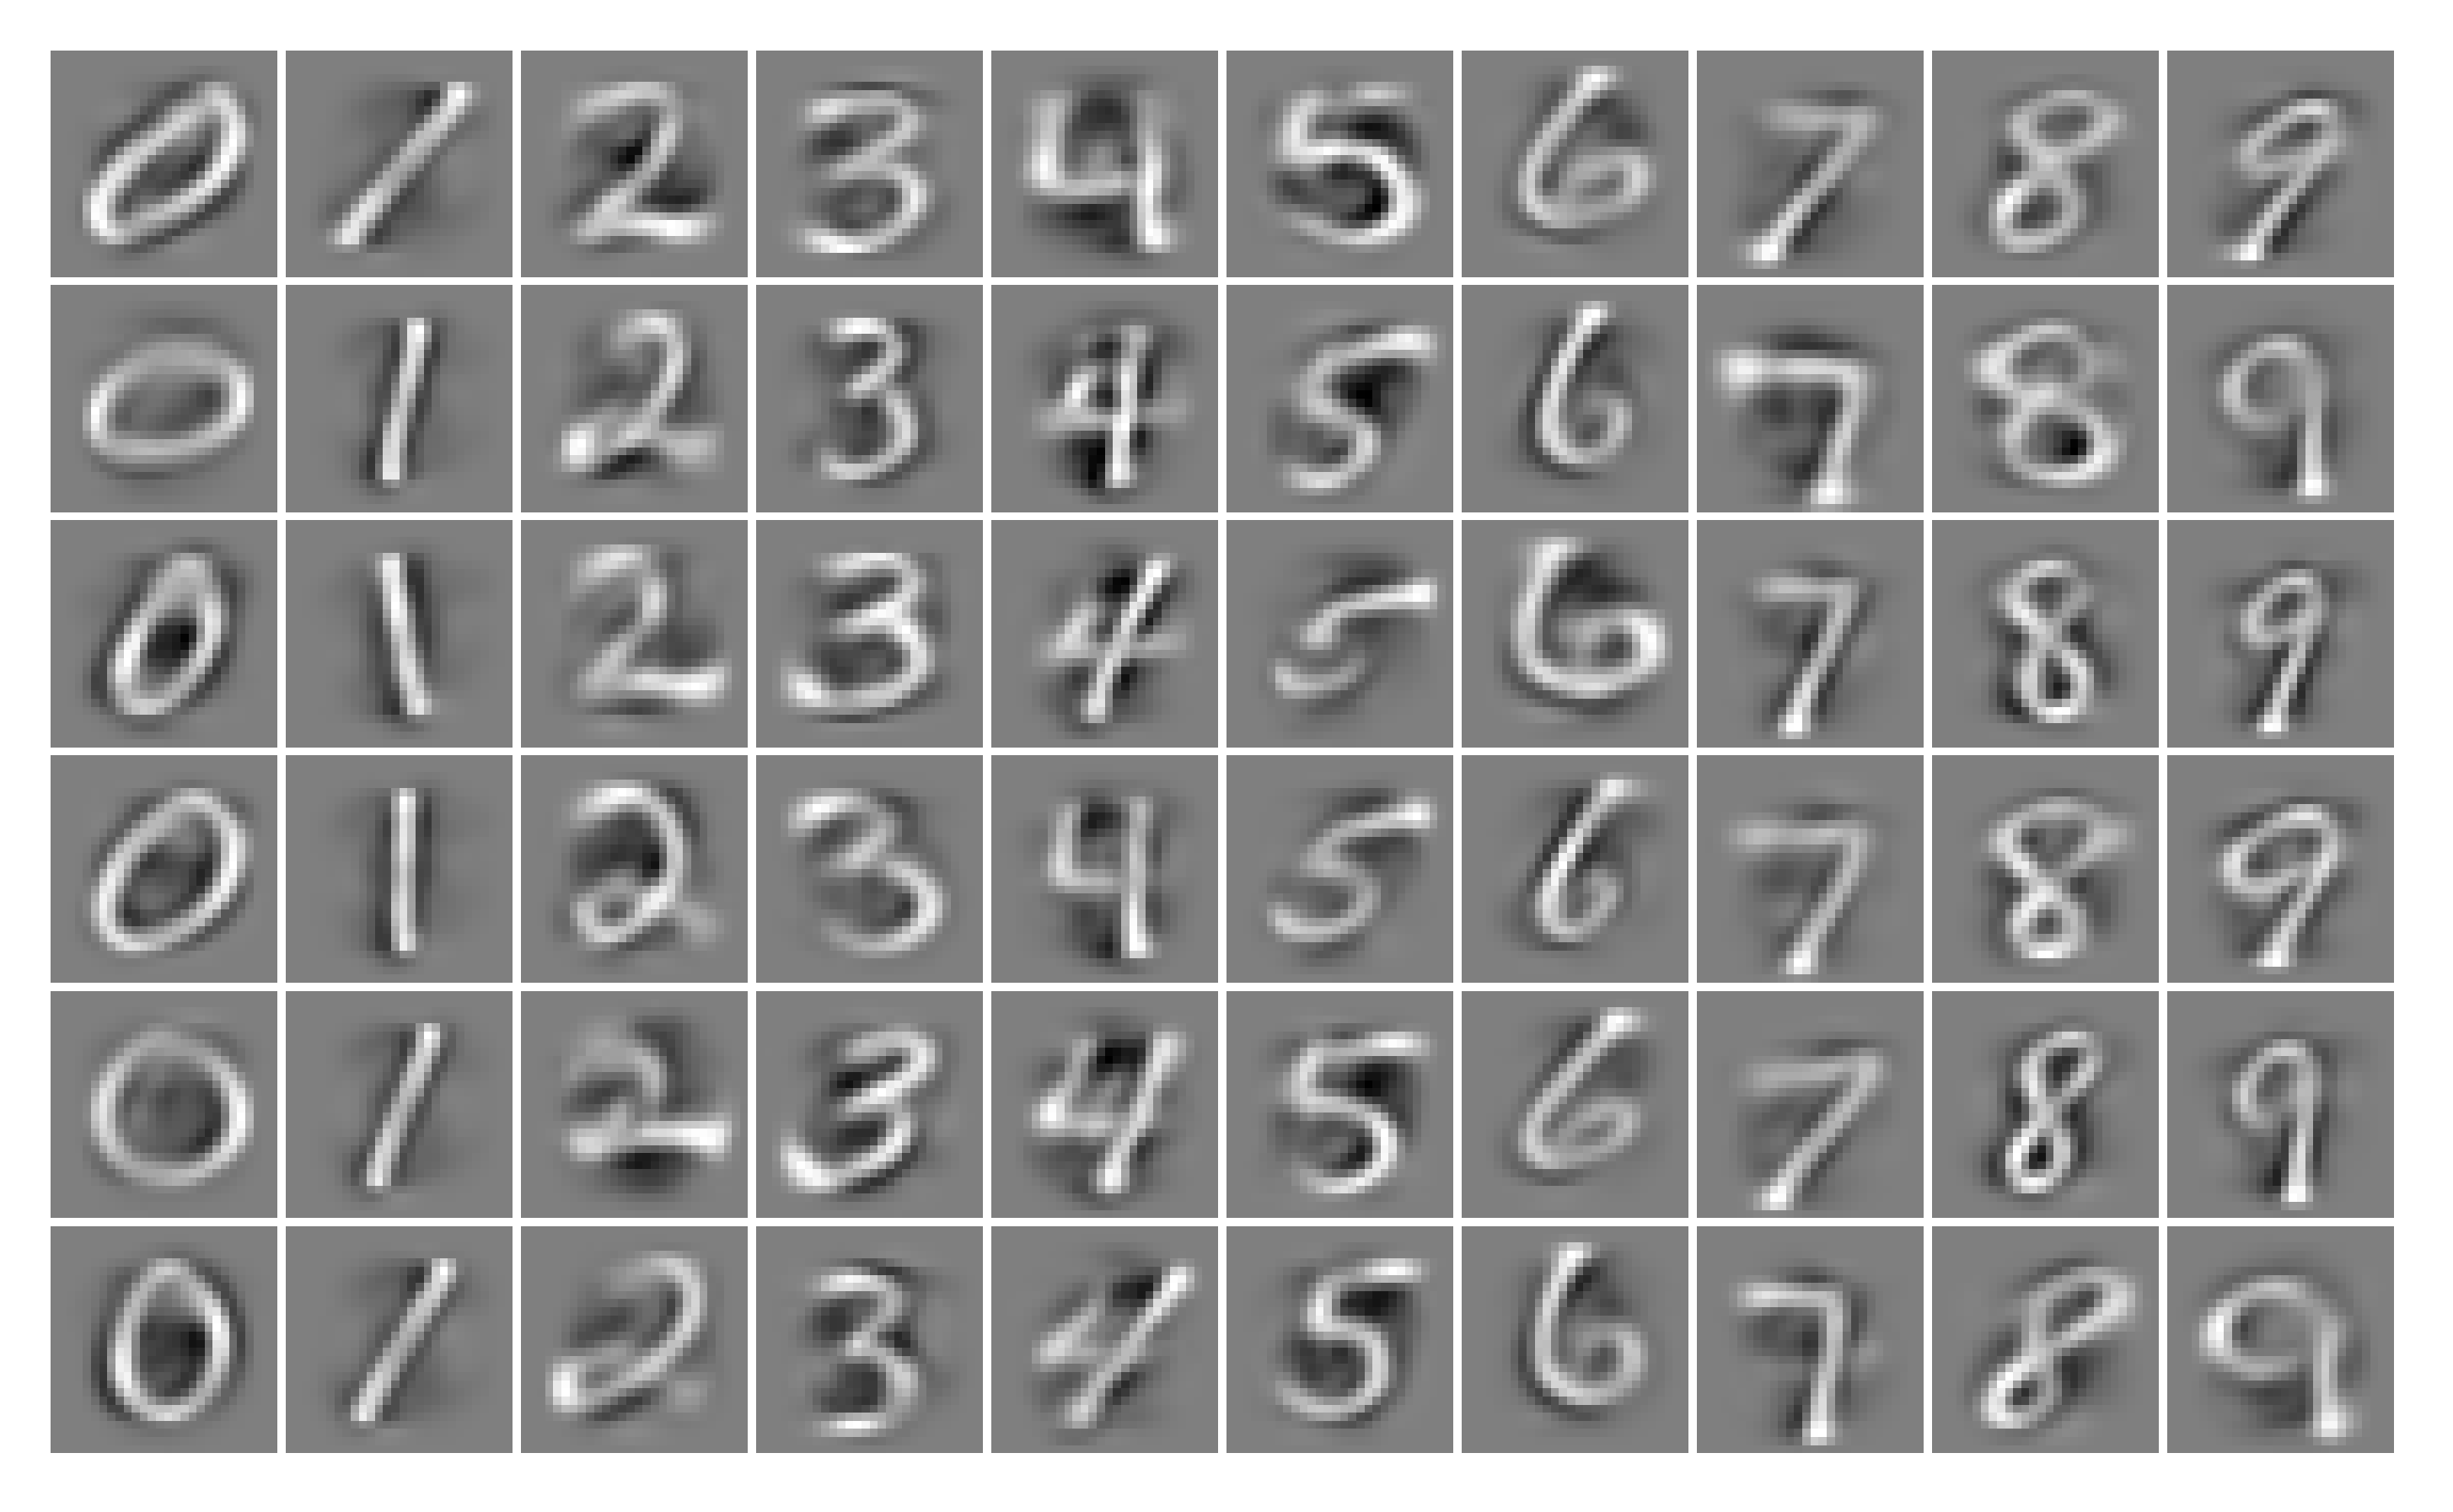

In [14]:
options = ['NN', 'Bayes', 'Max', 'Depict']
performExperiment ('ghiasi_svd', metric_learning = 'none', S2='St', reg = 1,  options=options)

solver =  ghiasi_svd metric_learning =  eig  regularions parameter =  1
lda.fitFeatureExtractor took time:  8.642441272735596
Objective:  7.347679154525489
Objective(SecondMethod):  7.347679154212723
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  282.94202971458435
Accuracy of Nearest Neighbor classifier is:  0.9726
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  8.906578063964844
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145
mnist_ghiasi_svd_eig_reg_1_0.png


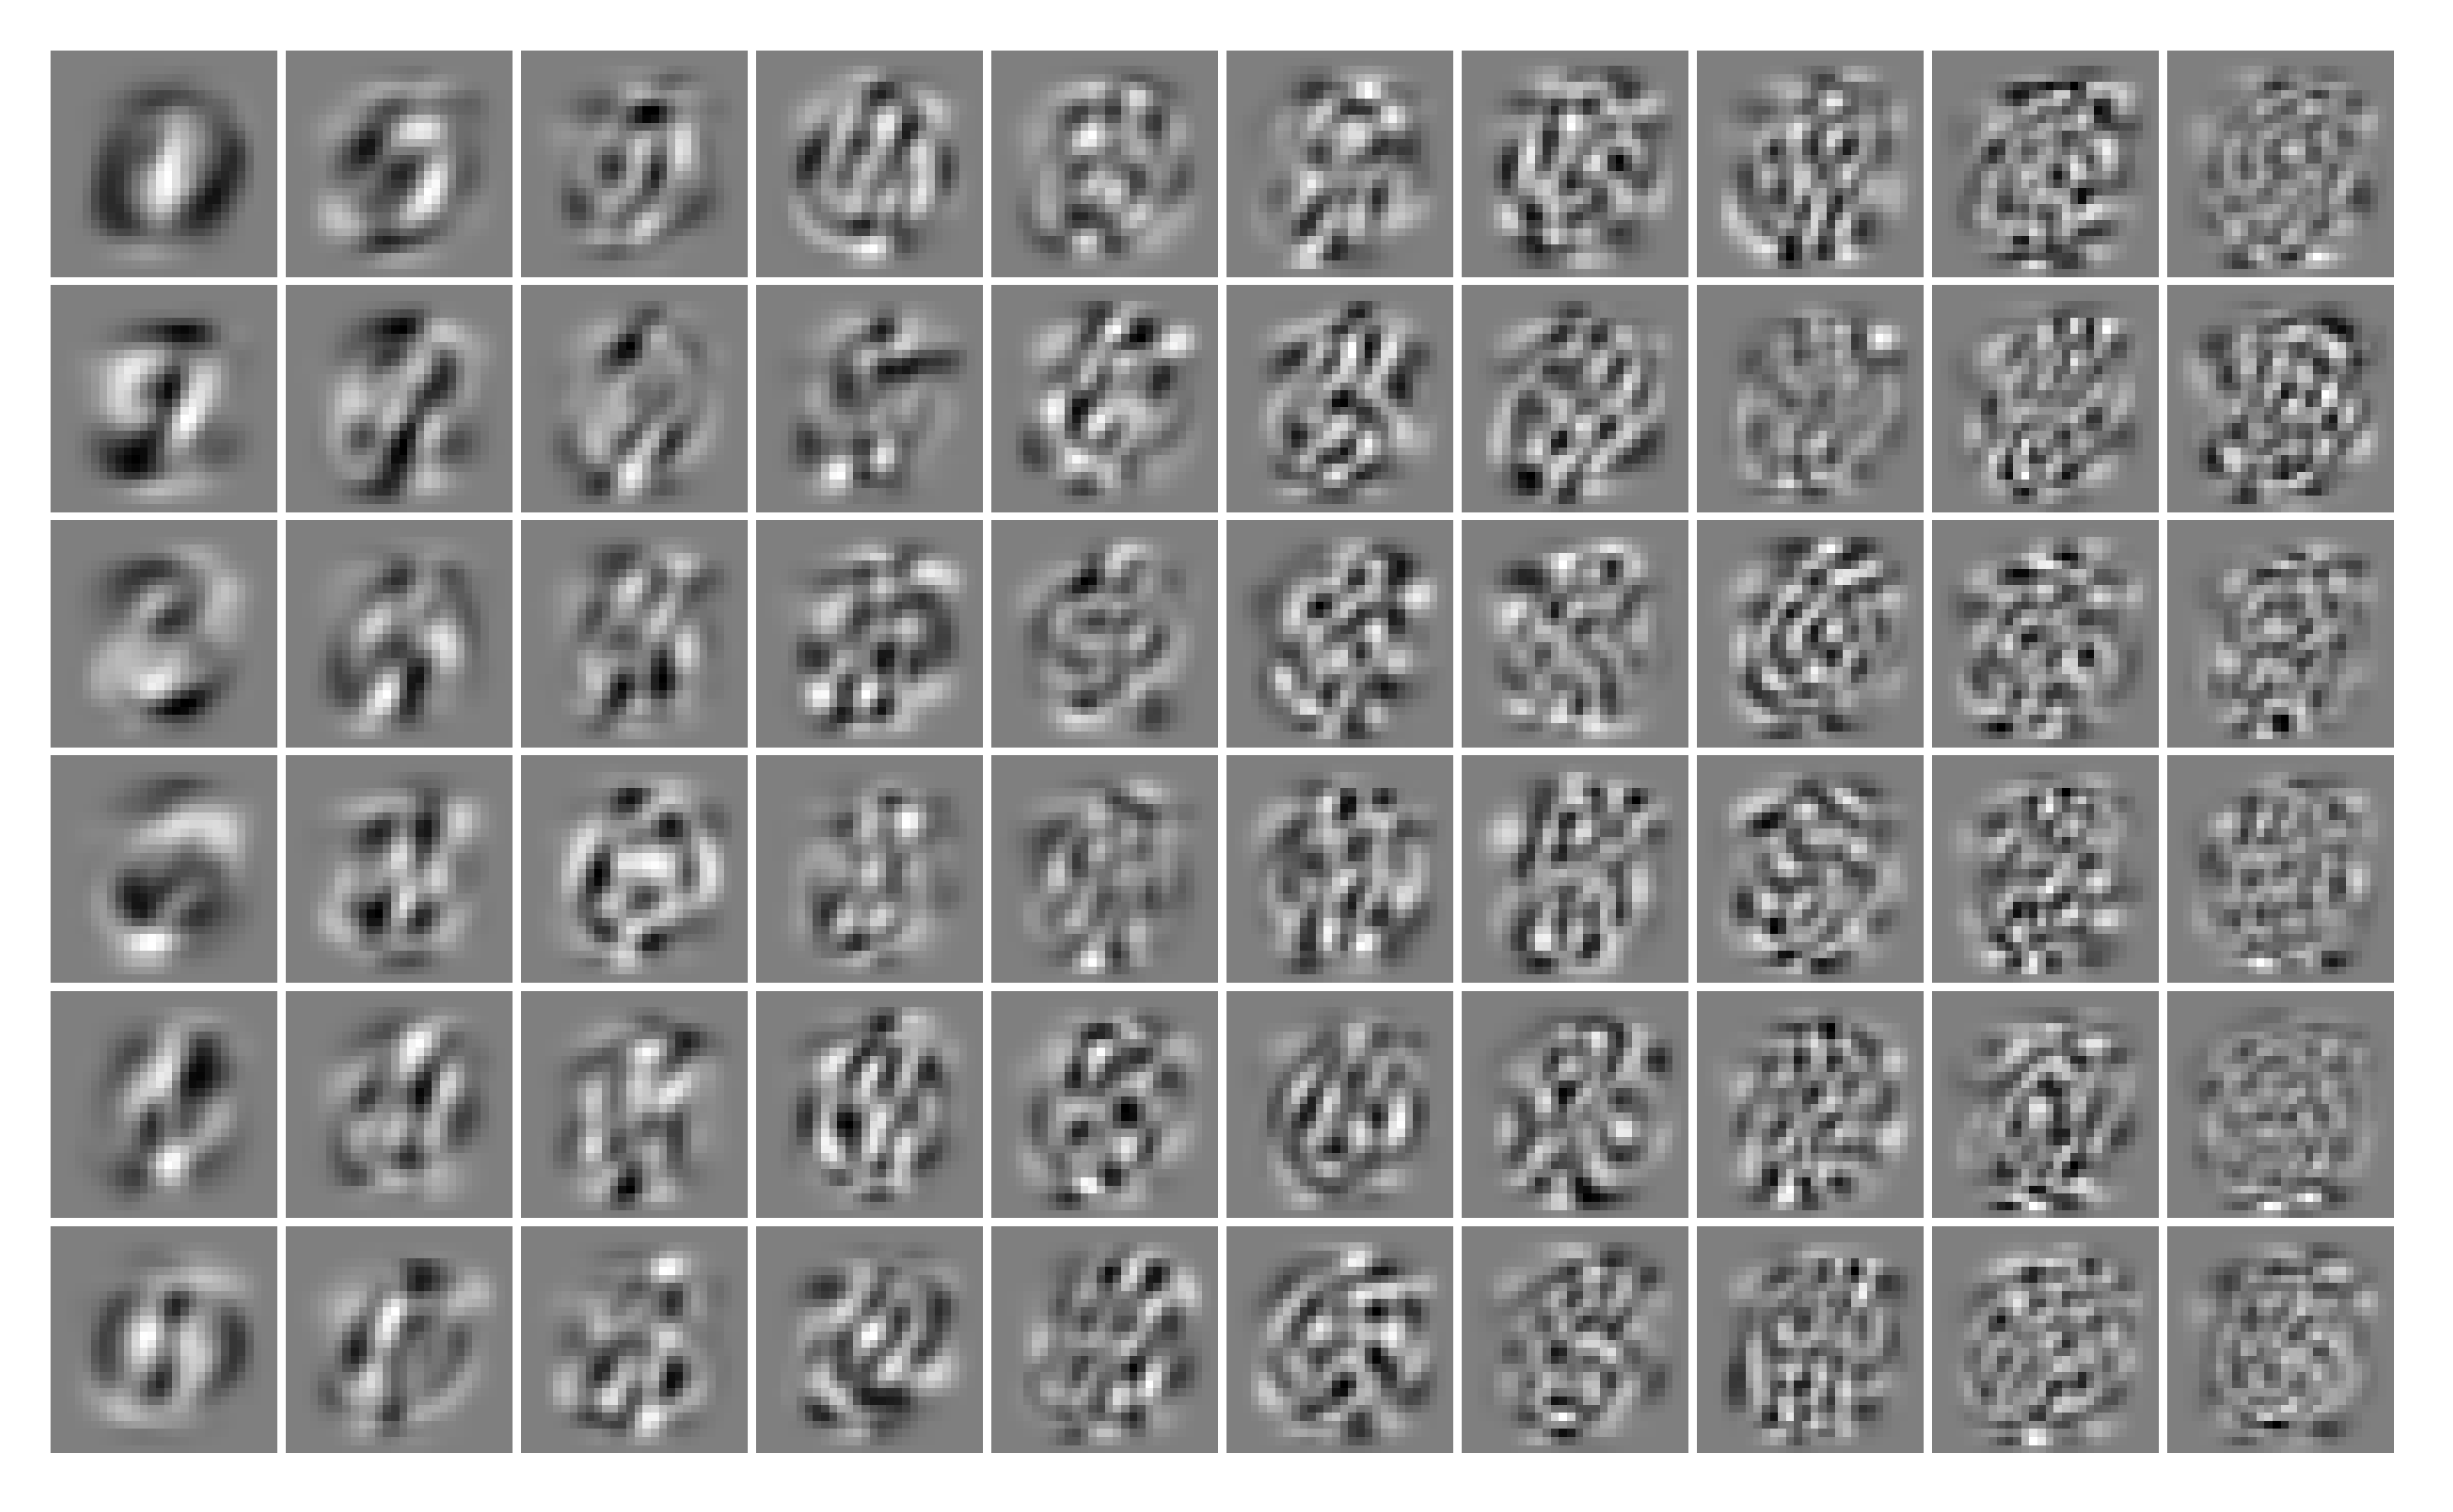

In [15]:
options = ['NN', 'Bayes', 'Max', 'Depict']
performExperiment (solver = 'ghiasi_svd', metric_learning = 'eig', S2='St', reg = 1,  options=options)

solver =  orthogonal_centroid metric_learning =    regularions parameter =  1
lda.fitFeatureExtractor took time:  0.0156252384185791
Objective:  7.332591194752514
Objective(SecondMethod):  7.3325911944424575
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  282.7146463394165
Accuracy of Nearest Neighbor classifier is:  0.9726
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  2.0613551139831543
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145
mnist_orthogonal_centroid__reg_1_0.png


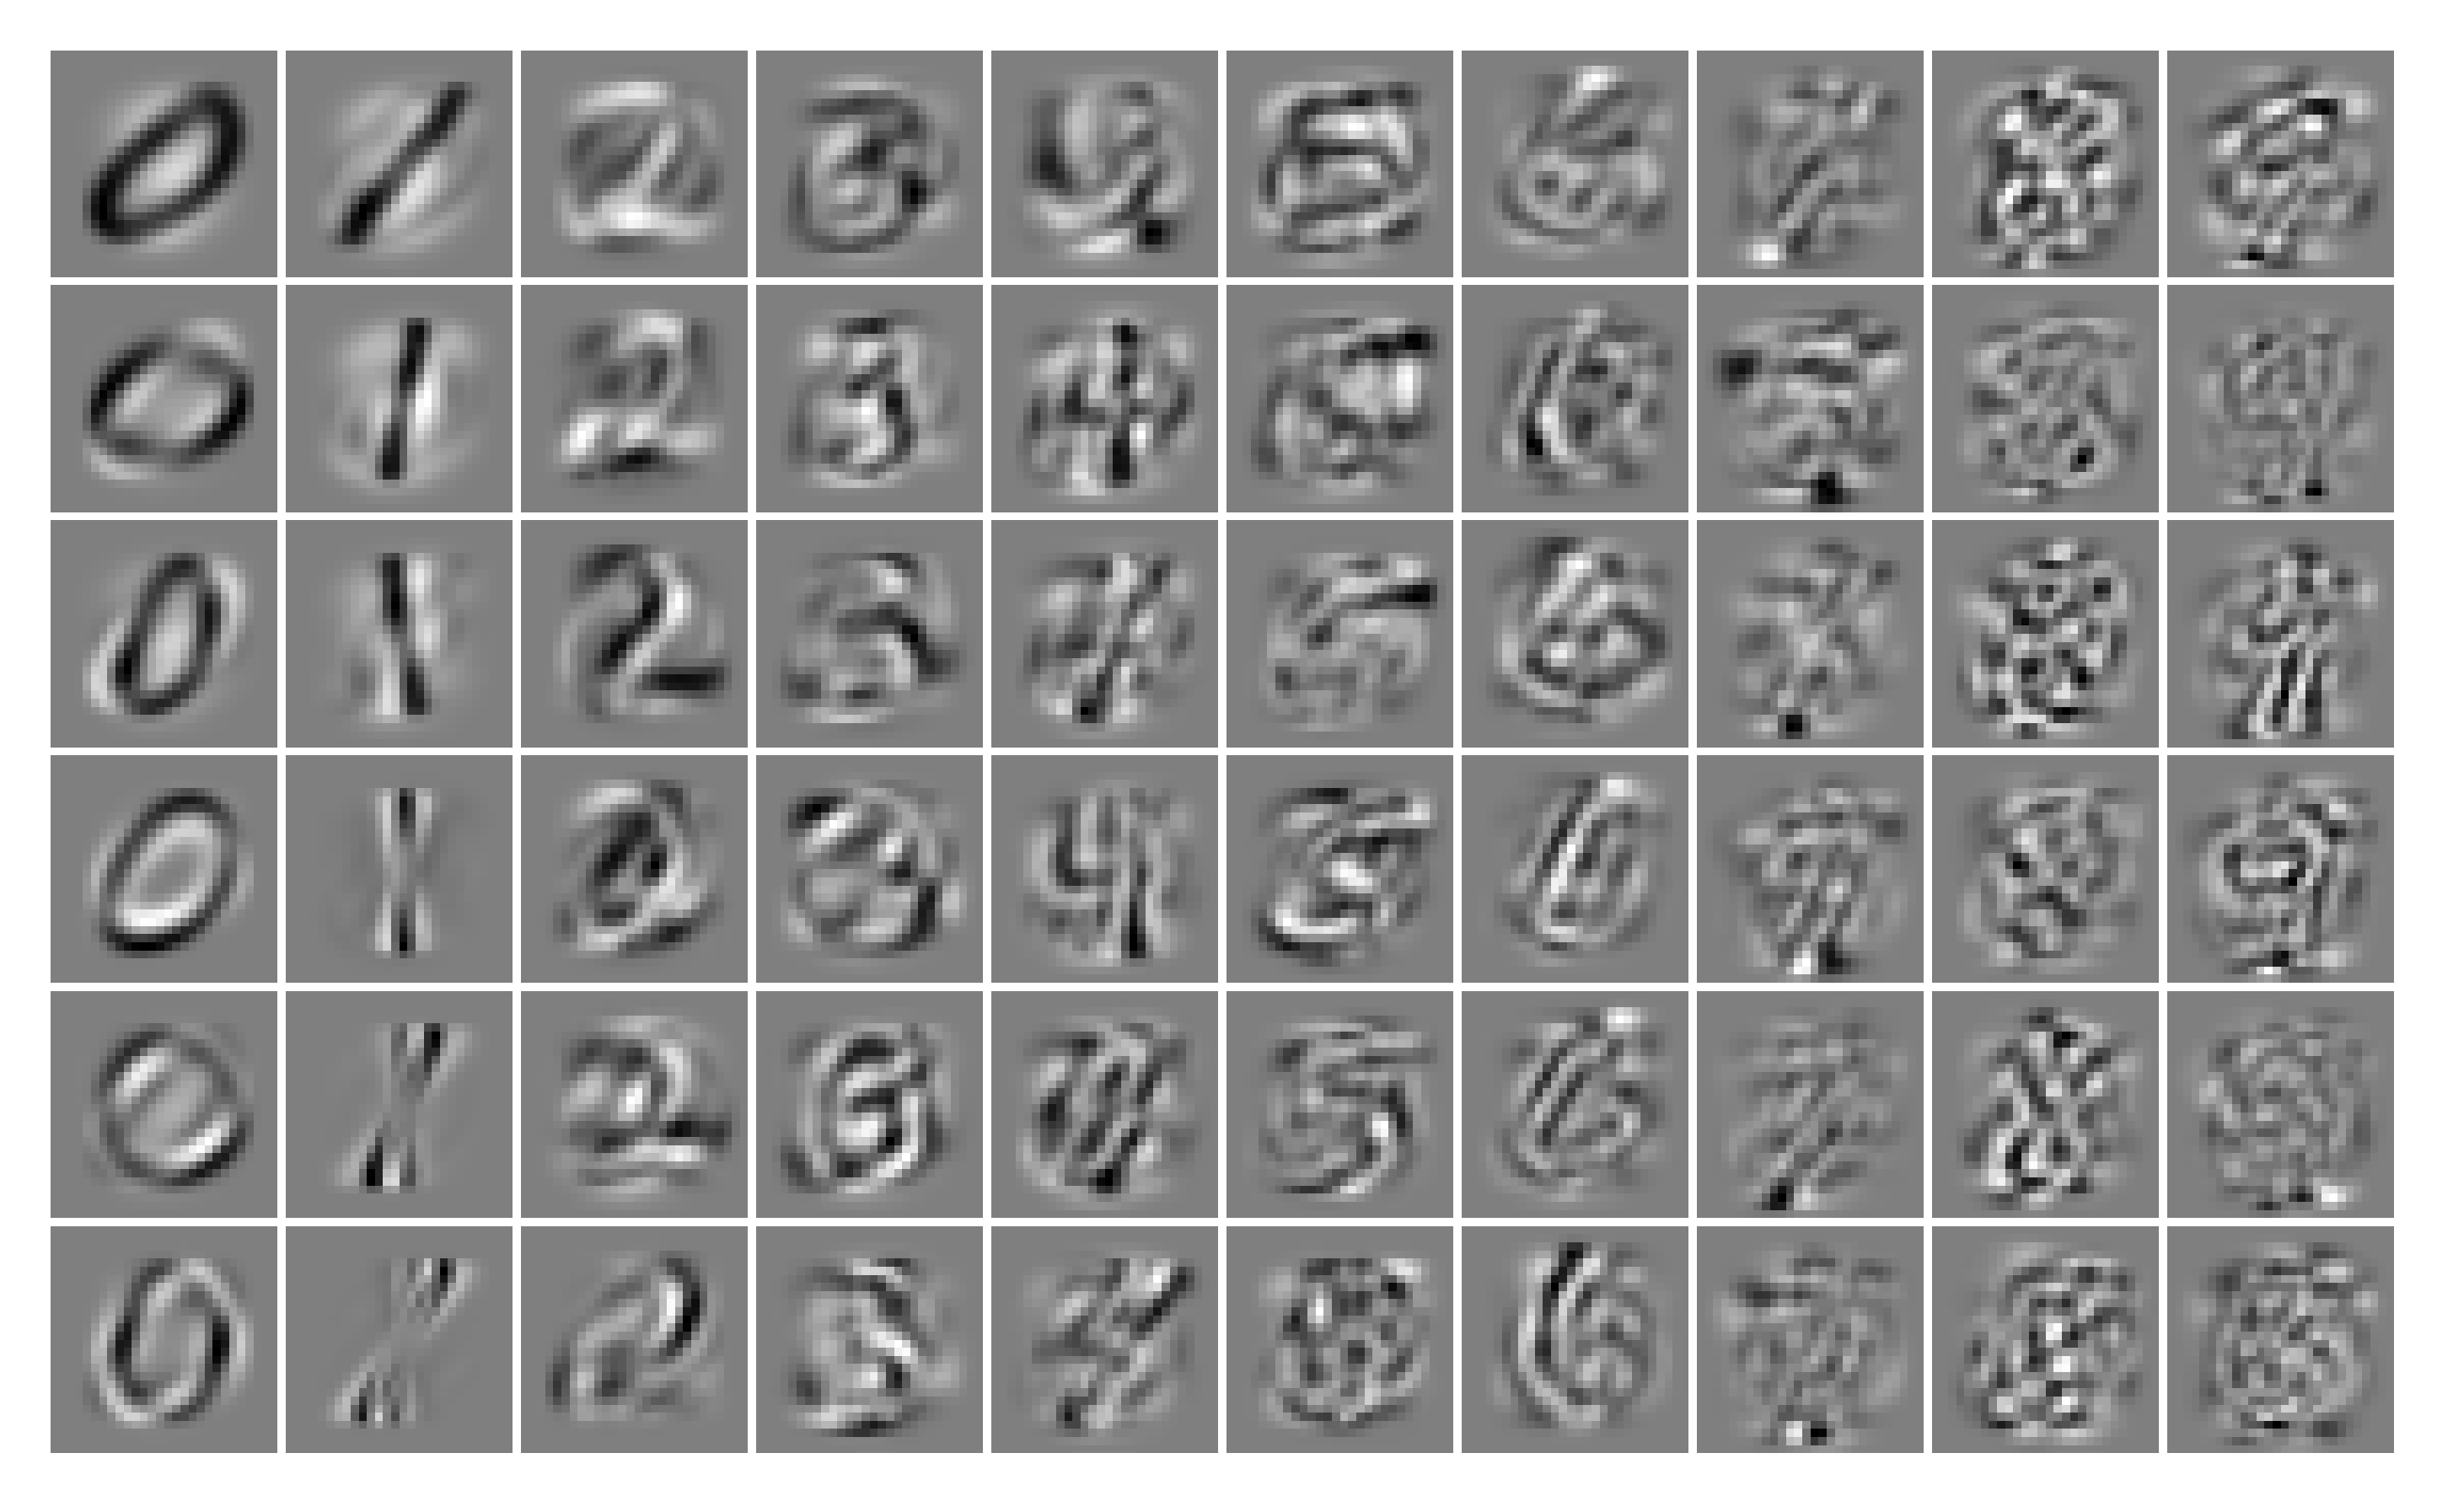

In [16]:
options = ['NN', 'Bayes', 'Max', 'Depict']
performExperiment (solver = 'orthogonal_centroid', metric_learning = '', S2='St', reg = 1,  options=options)

Note that the sligt difference in objective value compared with 'eigen' and 'lstsq' solvers stems from the regularization value which in 'svd' is applied only to non-zero diagonal elements and the fact that different numerical solvers (e.g. 'svd', 'lstsq', and 'eigen') yield sightly different solutions. 

### Running solvers with regularization paramater = 1e-10
We use a very small regularization value to ensure that solver='eigen' works.

In [17]:
#sovler='eigen' does not work with very low regularization parameters.
# So, instead of 1e-10, here we use 1e-4
options = ['Bayes', 'Max']
performExperiment (solver = 'eigen', metric_learning = '', S2='St', reg=1e-4,  options=options)

solver =  eigen metric_learning =    regularions parameter =  0.0001
lda.fitFeatureExtractor took time:  1.9323475360870361
Objective:  18.45201650110595
Objective(SecondMethod):  18.452016445627237
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  2.041290521621704
Test classification error: 0.8833
***Classification results based on max output***
Test classification error: 0.8824


In [18]:
#solver='lstsq' is much more accurate
performExperiment (solver = 'ghiasi_lstsq', metric_learning = 'none', S2='St', reg=1e-10,  options=options)

solver =  ghiasi_lstsq metric_learning =  none  regularions parameter =  1e-10
lda.fitFeatureExtractor took time:  2.000697135925293
Objective:  18.57058829079629
Objective(SecondMethod):  18.570513977426987
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  1.9891862869262695
Test classification error: 0.8818
***Classification results based on max output***
Test classification error: 0.8814


In [19]:
#solver='lstsq' is much more accurate
performExperiment (solver = 'ghiasi_lstsq', metric_learning = 'eig', S2='St', reg=1e-10,  options=options)

solver =  ghiasi_lstsq metric_learning =  eig  regularions parameter =  1e-10
lda.fitFeatureExtractor took time:  1.9868030548095703
Objective:  18.570588290796294
Objective(SecondMethod):  18.57056044504441
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  1.999359130859375
Test classification error: 0.8818
***Classification results based on max output***
Test classification error: 0.8814


In [20]:
performExperiment (solver = 'svd', metric_learning = '', S2='St',reg = 1e-10,  options=options)

solver =  svd metric_learning =    regularions parameter =  1e-10
lda.fitFeatureExtractor took time:  8.422444343566895
Objective:  18.570495367665703
Objective(SecondMethod):  18.5704777668688
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  8.86444354057312
Test classification error: 0.8819
***Classification results based on max output***
Test classification error: 0.8814


In [21]:
performExperiment (solver = 'ghiasi_svd', metric_learning = 'none', S2='St', reg = 1e-10,  options=options)

solver =  ghiasi_svd metric_learning =  none  regularions parameter =  1e-10
lda.fitFeatureExtractor took time:  8.370725870132446
Objective:  18.570495367665693
Objective(SecondMethod):  18.57044789923142
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  8.848949193954468
Test classification error: 0.8819
***Classification results based on max output***
Test classification error: 0.8814


In [22]:
performExperiment (solver = 'ghiasi_svd', metric_learning = 'eig', S2='St', reg = 1e-10,  options=options)

solver =  ghiasi_svd metric_learning =  eig  regularions parameter =  1e-10
lda.fitFeatureExtractor took time:  8.40717887878418
Objective:  18.570495367665703
Objective(SecondMethod):  18.570477766868798
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  9.237840414047241
Test classification error: 0.8819
***Classification results based on max output***
Test classification error: 0.8814


### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>